In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
sns.set_style("whitegrid")
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('display.width', 200)
pd.set_option('display.colheader_justify', 'center')
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Import additional libraries
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [2]:
# Load the dataset
df = pd.read_excel('_data/_matches_list_v5.xlsx')

### DATA PREPARATION ###

##### Remove redundant columns (Feature Selection) #####

In [3]:
# Show that best_of and is_grandSlam are the same features; as a result, we will not use best_of in our feature selection
pd.crosstab(df['best_of'], df['is_grandSlam'])

is_grandSlam    0      1 
best_of                  
3             27441     0
5                 0  6680

In [4]:
# Define the target columns
target_col = 'p1_won'

# Define the variables
variable_cols = ['year',
                'diff_Avg_implied',
                'diff_rank', 'diff_rank_log', 'diff_rankpt', 'diff_rankpt_log',
                'diff_firstServeInRatio', 'diff_firstServeWinRatio', 'diff_secondServeWinRatio',
                'diff_overallServeWinRatio', 'diff_overallReturnWinRatio',
                'diff_completeness',
                'diff_acePerServePoint', 'diff_dfPerServePoint', 'diff_acePerServeGame', 'diff_dfPerServeGame',
                'diff_bpSaveRatio',
                'is_grandSlam', 'is_formerTop10',
                'diff_homeAdvantage',
                'diff_ht', 'diff_seed', 
                'diff_age', 'diff_agePersonalPeak', 'diff_ageGeneralPeak',
                'diff_gamesFatigue',
                'diff_rankMomentum_log', 'diff_rankptMomentum_log',
                'diff_avgDuration',
                'diff_surfaceAdvantage', 'diff_surfaceWinRatio', 'diff_overallWinRatio', 
                'diff_h2hWinRatio', 'diff_winLossStreak',
                'tourney_level', 'court', 'surface', 'draw_size', 'round', 'handedness',
]

# Get the list of columns that are not in variable_cols
df.columns.difference(variable_cols)

Index(['best_of', 'favorite_won', 'match_date', 'match_id', 'minutes', 'p1_1stIn', 'p1_1stWon', 'p1_2ndIn', 'p1_2ndWon', 'p1_Avg', 'p1_Avg_implied', 'p1_Max', 'p1_Max_implied', 'p1_RcGmsWon',
       'p1_SvGms', 'p1_SvGmsWon', 'p1_ace', 'p1_acePerServeGame', 'p1_acePerServePoint', 'p1_age', 'p1_agePersonalPeak', 'p1_bpFaced', 'p1_bpSaveRatio', 'p1_bpSaved', 'p1_completeness', 'p1_df',
       'p1_dfPerServeGame', 'p1_dfPerServePoint', 'p1_entry', 'p1_firstServeInRatio', 'p1_firstServeWinRatio', 'p1_games', 'p1_games_ratio', 'p1_hand', 'p1_ht', 'p1_id', 'p1_ioc', 'p1_name',
       'p1_overallReturnWinRatio', 'p1_overallServeWinRatio', 'p1_points', 'p1_points_ratio', 'p1_rank', 'p1_rankpt', 'p1_secondServeWinRatio', 'p1_seed', 'p1_sets', 'p1_sets_ratio', 'p1_svpt',
       'p1_won', 'p2_1stIn', 'p2_1stWon', 'p2_2ndIn', 'p2_2ndWon', 'p2_Avg', 'p2_Avg_implied', 'p2_Max', 'p2_Max_implied', 'p2_RcGmsWon', 'p2_SvGms', 'p2_SvGmsWon', 'p2_ace', 'p2_acePerServeGame',
       'p2_acePerServePoint', '

##### Train-Test Split #####

In [5]:
# Function to split the data based on year
def train_test_split_by_year(df, variable_cols, target_col):
    # Train-test split based on the 'year' column
    X_train = df[df['year'] <= 2020][variable_cols]
    y_train = df[df['year'] <= 2020][target_col]

    X_test = df[df['year'] > 2020][variable_cols]
    y_test = df[df['year'] > 2020][target_col]

    # Check the shapes
    print(f"Train-test split for target column {target_col}")
    print("Shapes:", X_train.shape, y_train.shape, X_test.shape, y_test.shape)
    
    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = train_test_split_by_year(df, variable_cols, target_col)


Train-test split for target column p1_won
Shapes: (29166, 40) (29166,) (4955, 40) (4955,)


##### Feature Encoding #####

In [6]:
# Function to encode the features
def encode_features(df):
    ### Encode tourney_level
    order = {'A':1, 'M':2, 'F':3, 'G':4}
    df['ord_tourneyLevel'] = df['tourney_level'].map(order)

    ### Encode court
    order = {'Indoor': 0, 'Outdoor': 1}
    df['is_outdoor'] = df['court'].map(order)

    ### One-Hot Encode surface
    df = pd.get_dummies(df, columns=['surface'], prefix='surface')

    # Encode draw_size
    order = {8: 1, 16: 2, 28: 3, 32: 4, 48: 5, 56: 6, 64: 7, 96: 8, 128: 9}
    df['ord_drawSize'] = df['draw_size'].map(order)

    ### Encode round
    order = {'R128': 1, 'R64': 2, 'R32': 3, 'R16': 4, 'QF': 5, 'RR': 5, 'SF': 6, 'F': 7}
    df['ord_round'] = df['round'].map(order)

    ### One-Hot Encode handedness
    df = pd.get_dummies(df, columns=['handedness'], prefix='handedness')
    
    return df

X_train = encode_features(X_train)
X_test = encode_features(X_test)


In [7]:
# Remove the encoded features from the feature_cols
feature_cols = [col for col in variable_cols if col not in ['tourney_level', 'court', 'surface', 'draw_size', 'round', 'handedness']]

# Add the newly encoded features to the feature_cols
feature_cols += ['ord_tourneyLevel', 'is_outdoor',
                'surface_Clay', 'surface_Grass', 'surface_Hard',
                'ord_drawSize', 'ord_round',
                'handedness_L', 'handedness_LR', 'handedness_R', 'handedness_RL',
                ]

# Remove columns in X_train and X_test that are not in feature_cols
X_train = X_train[feature_cols]
X_test = X_test[feature_cols]

##### Feature Scaling #####

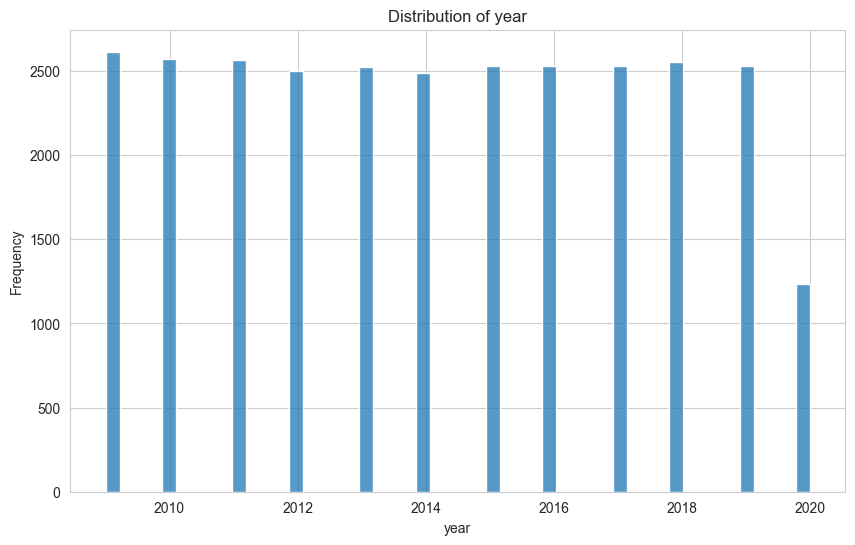

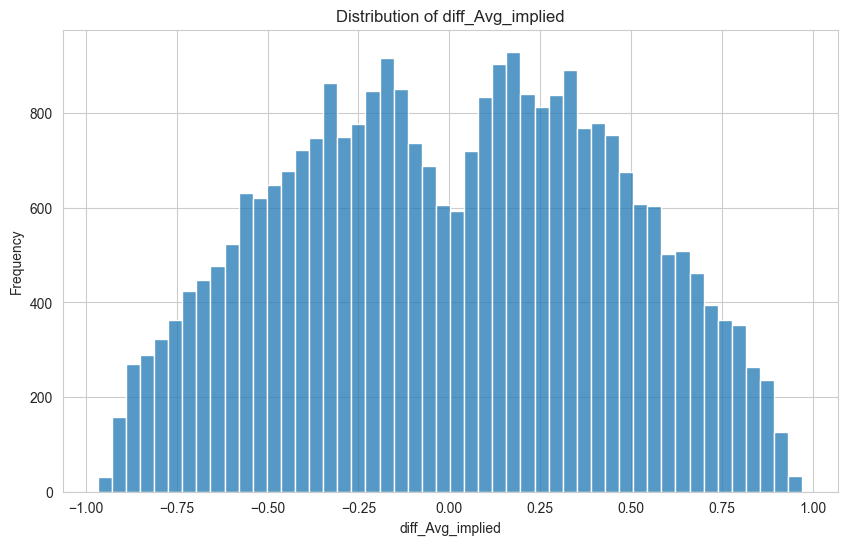

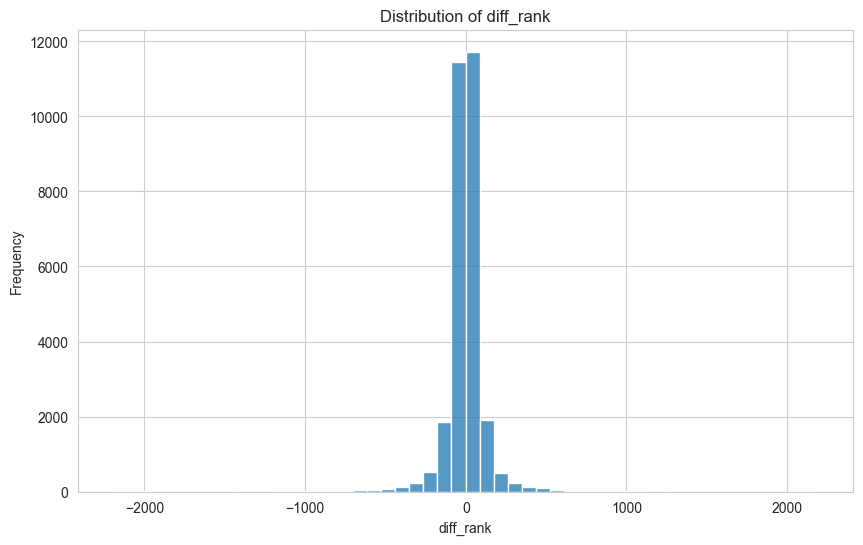

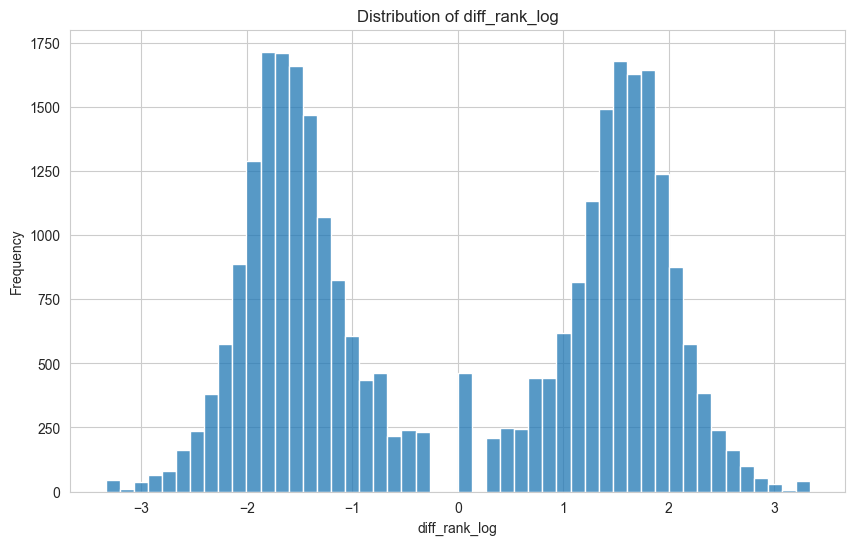

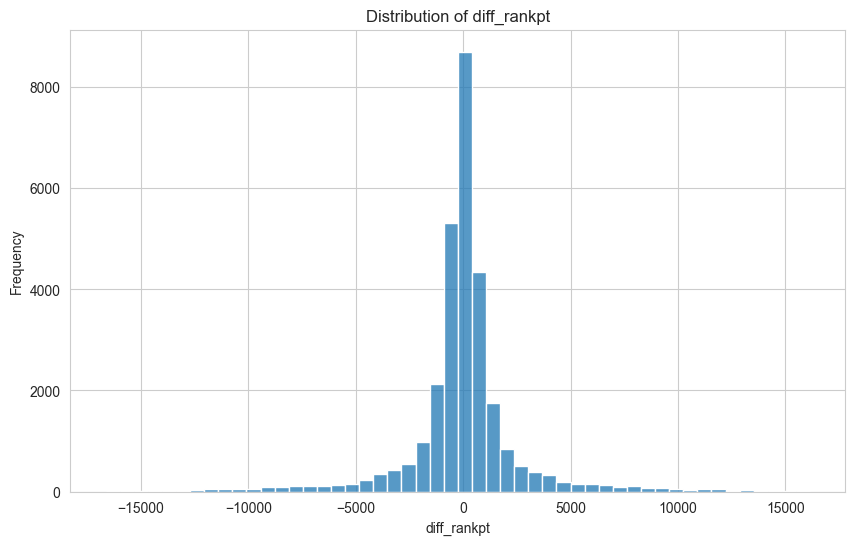

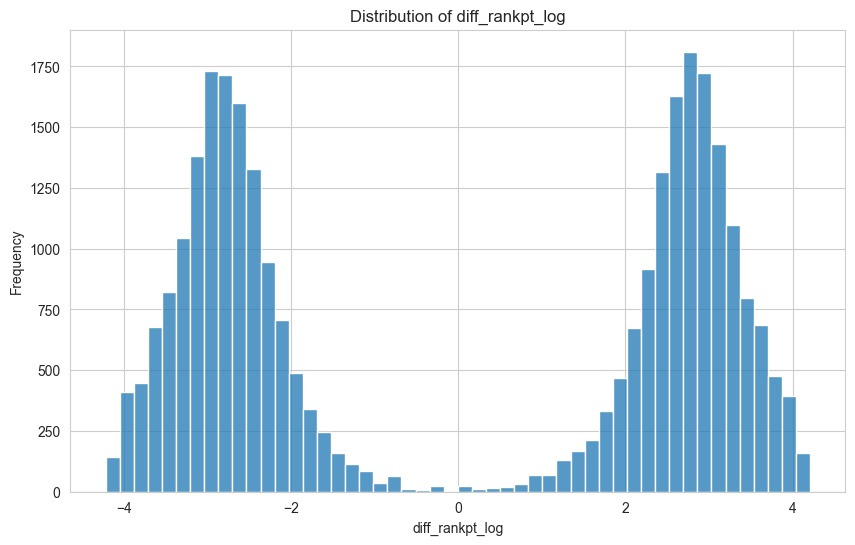

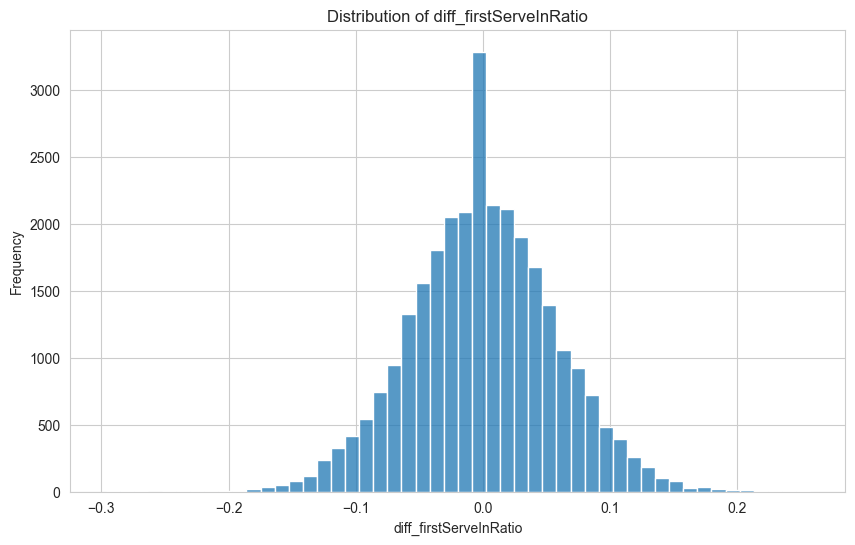

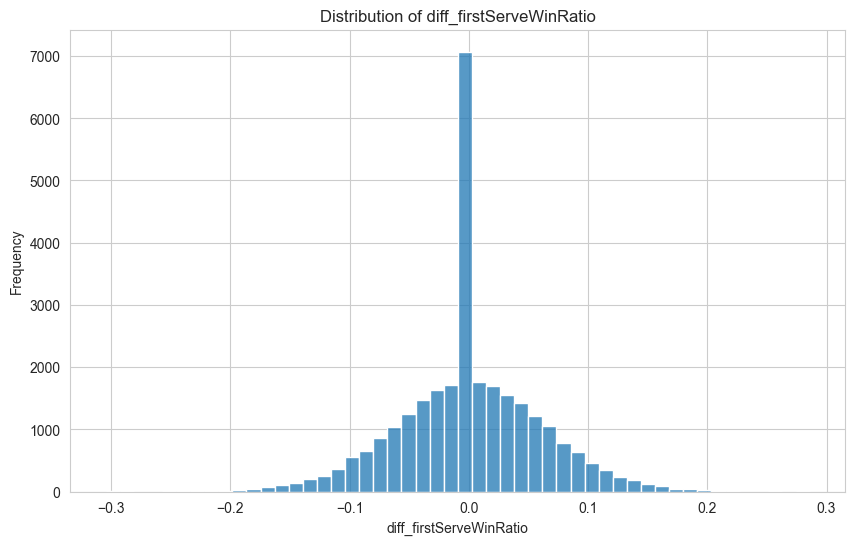

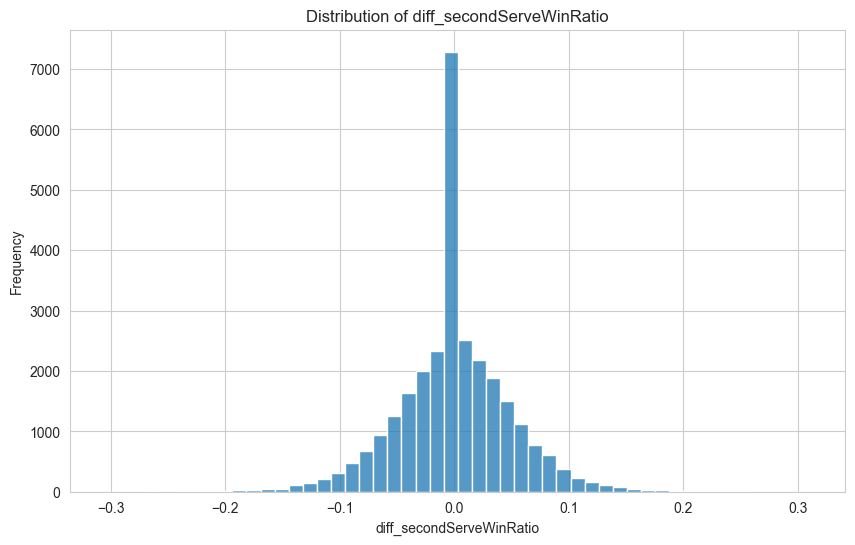

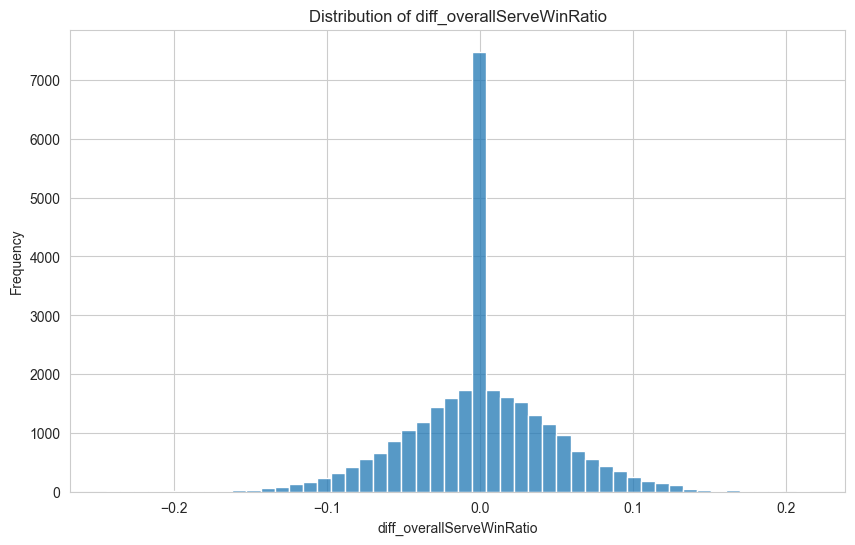

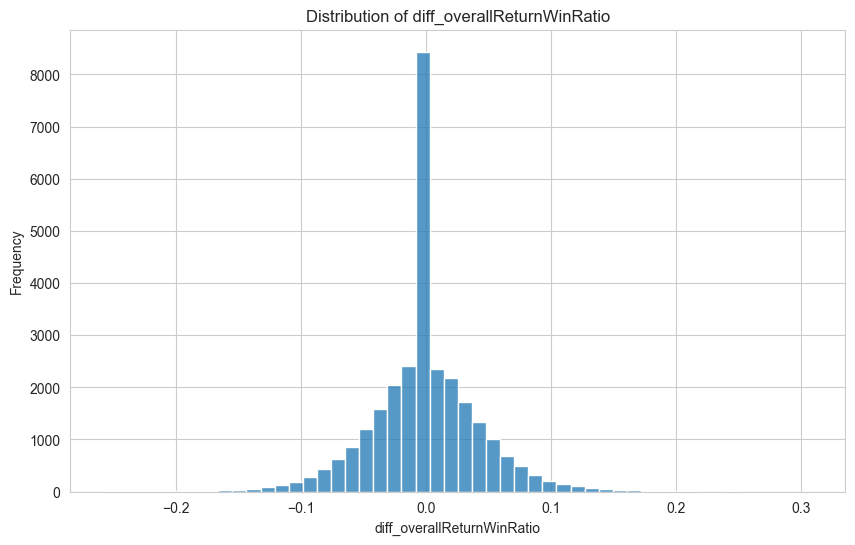

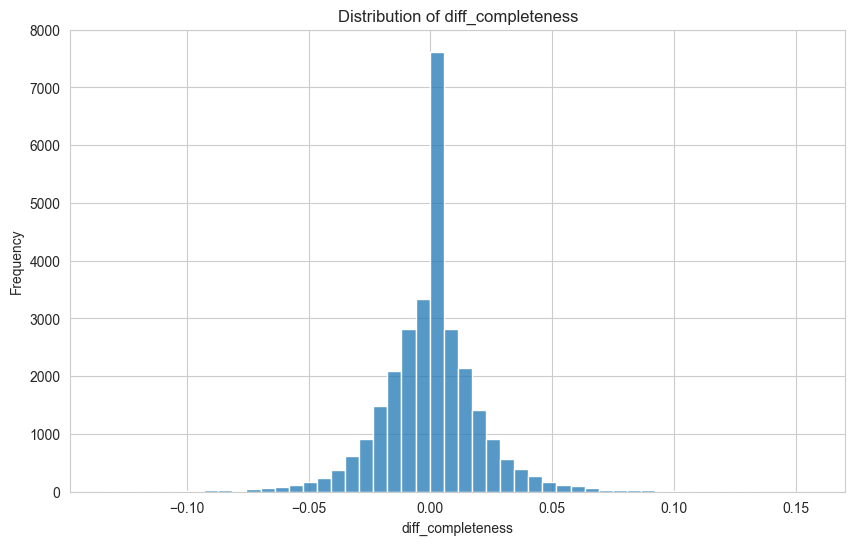

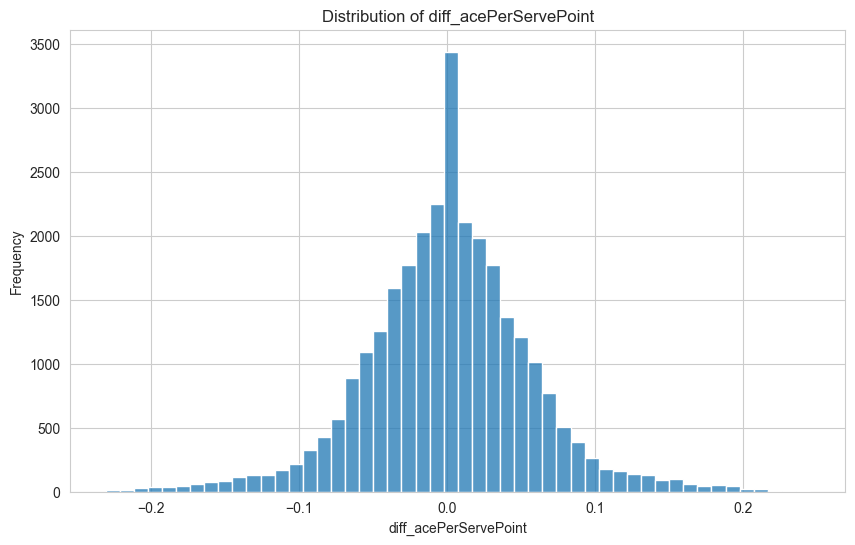

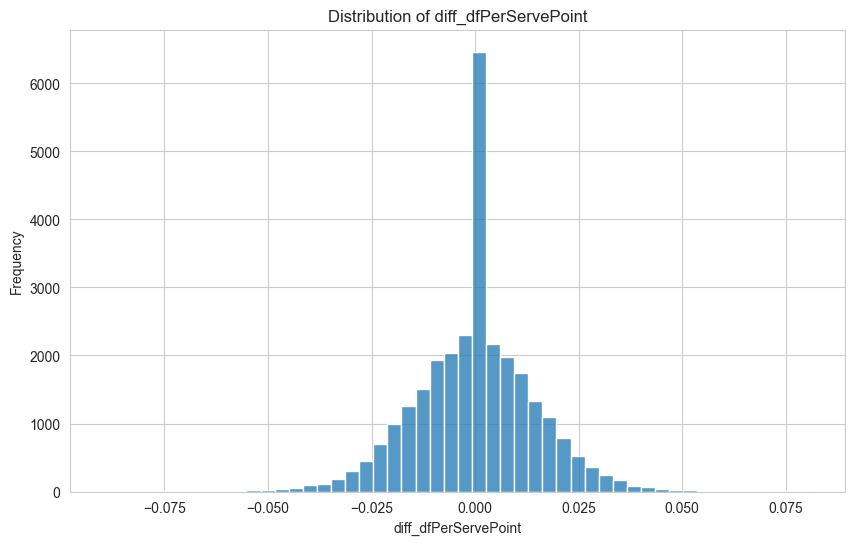

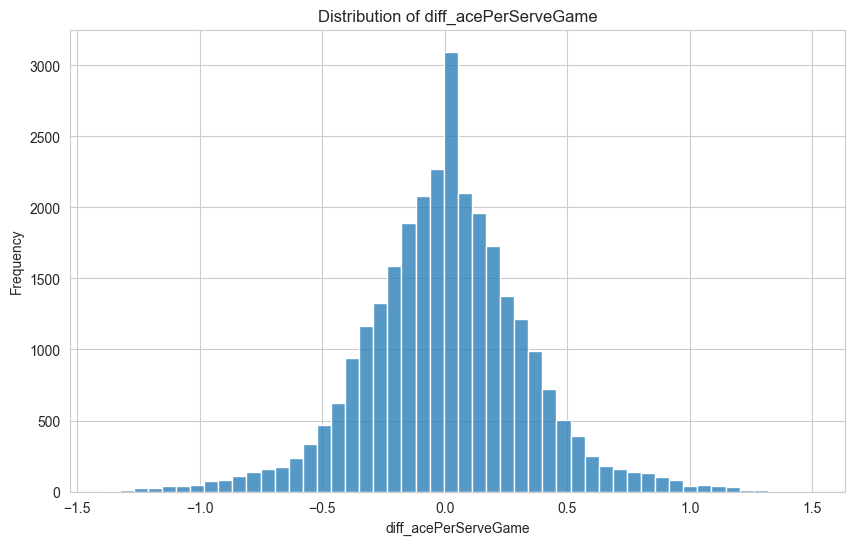

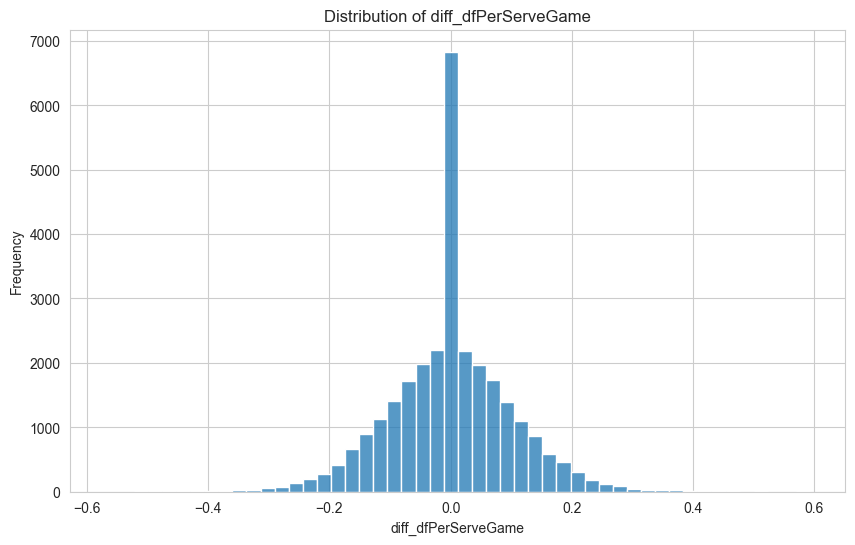

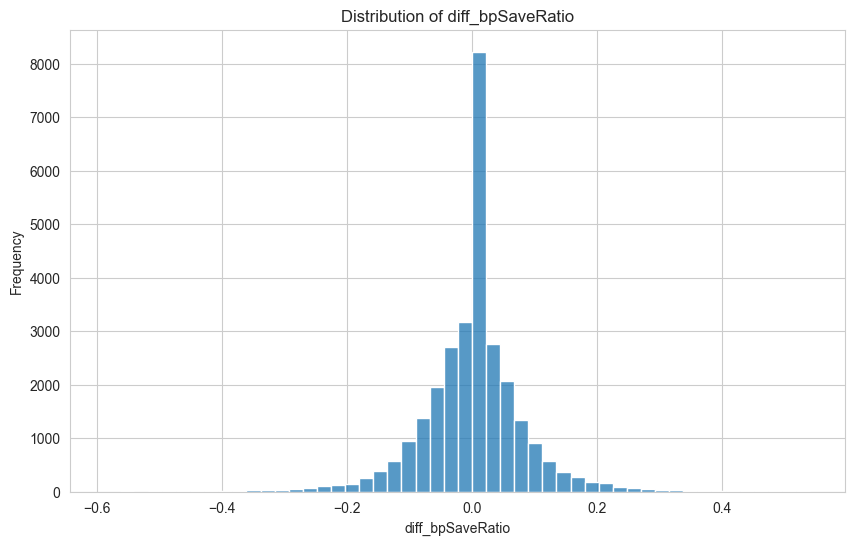

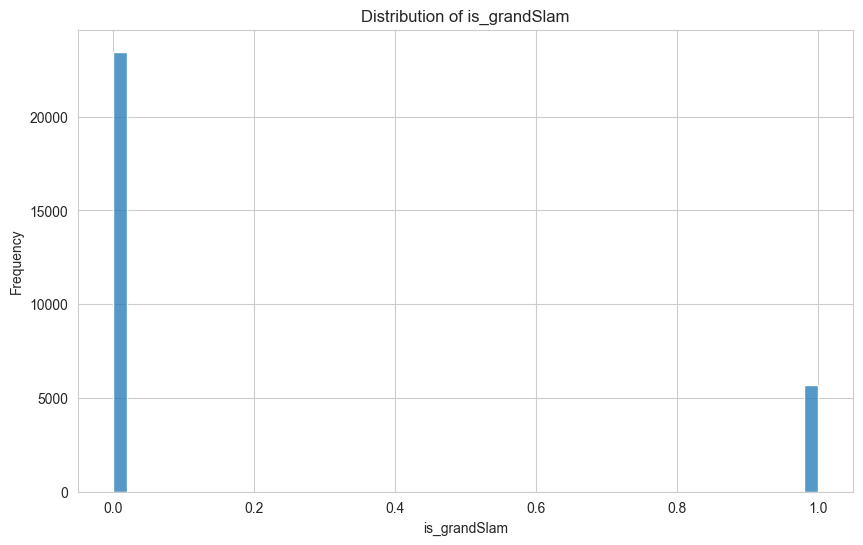

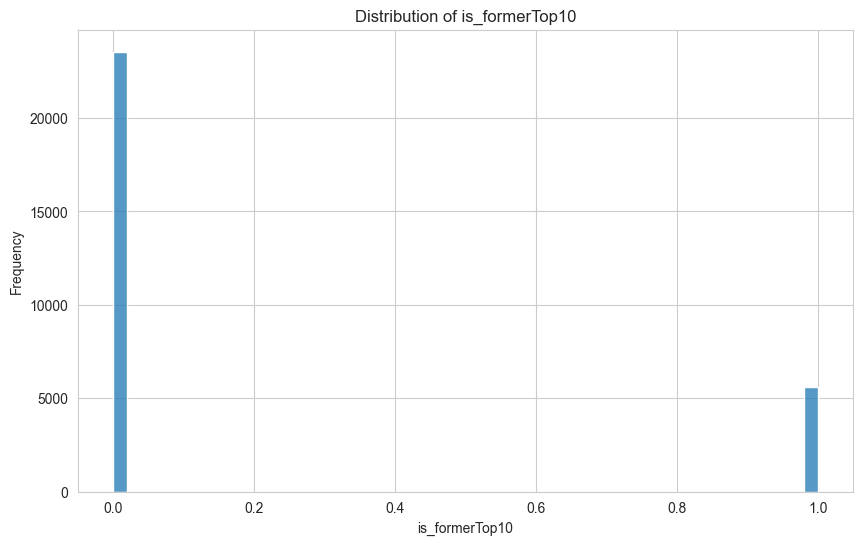

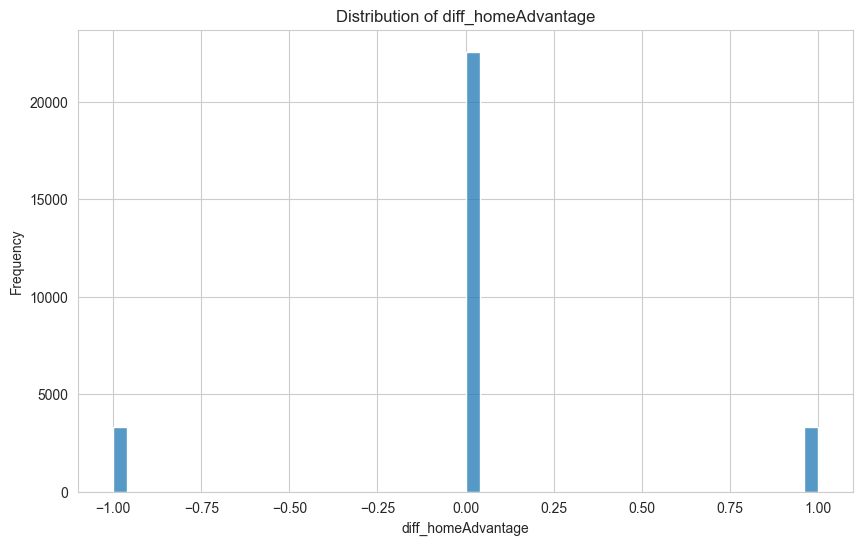

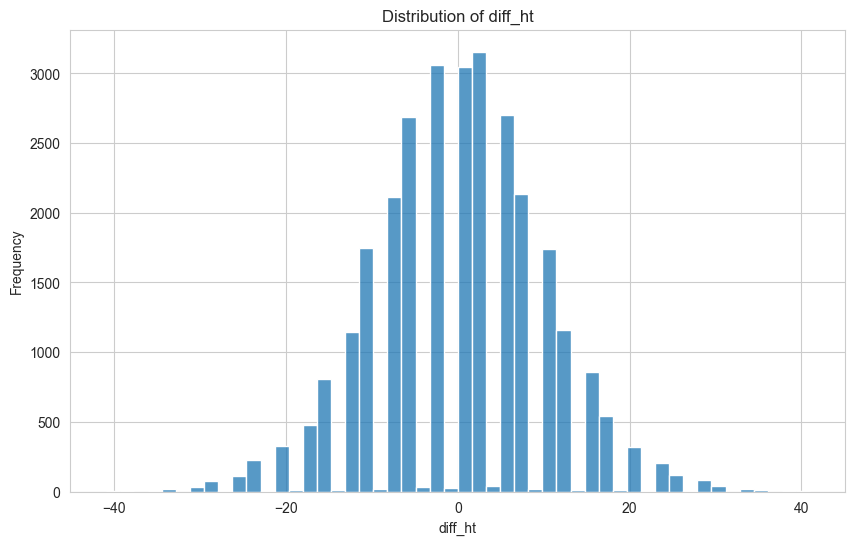

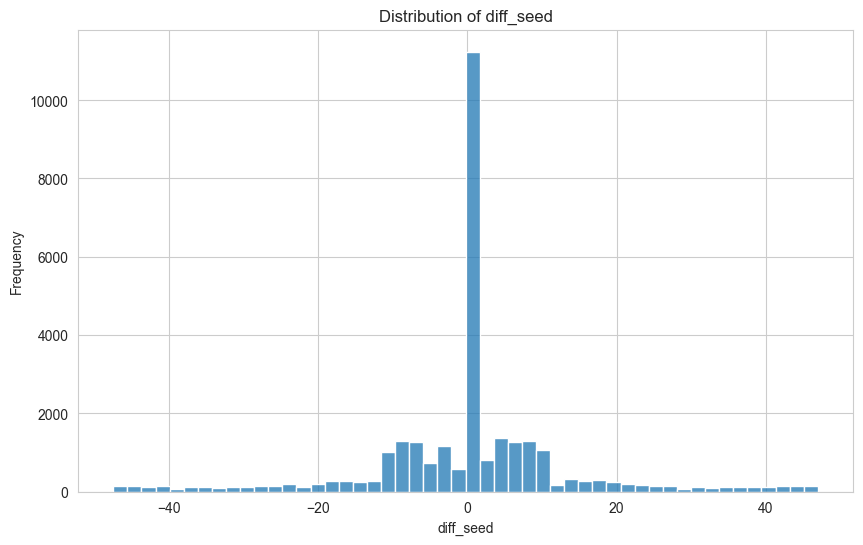

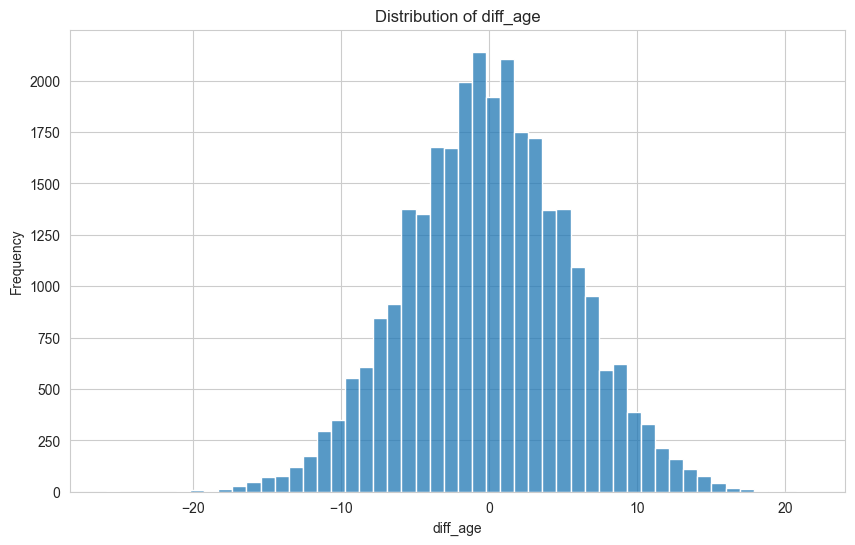

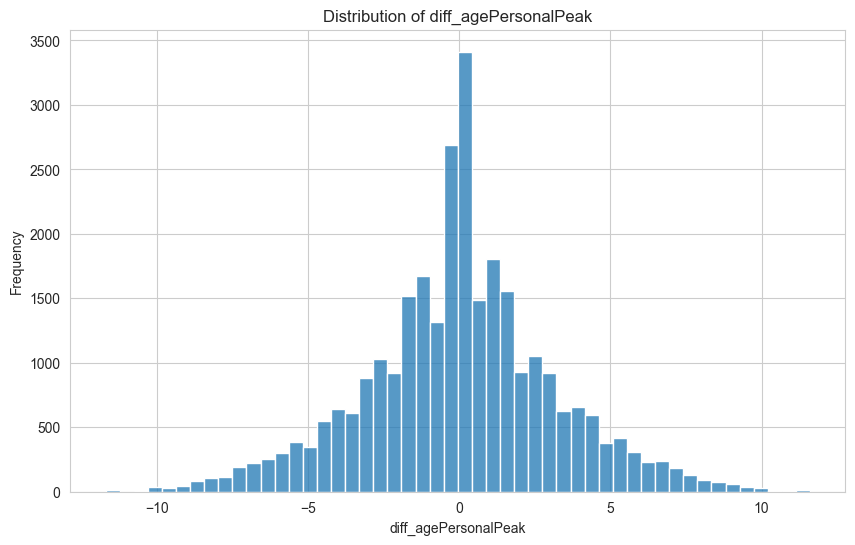

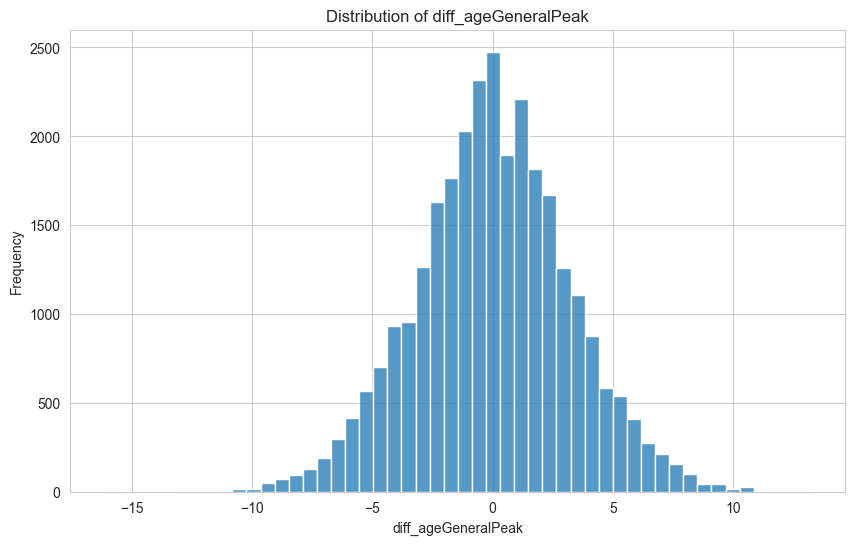

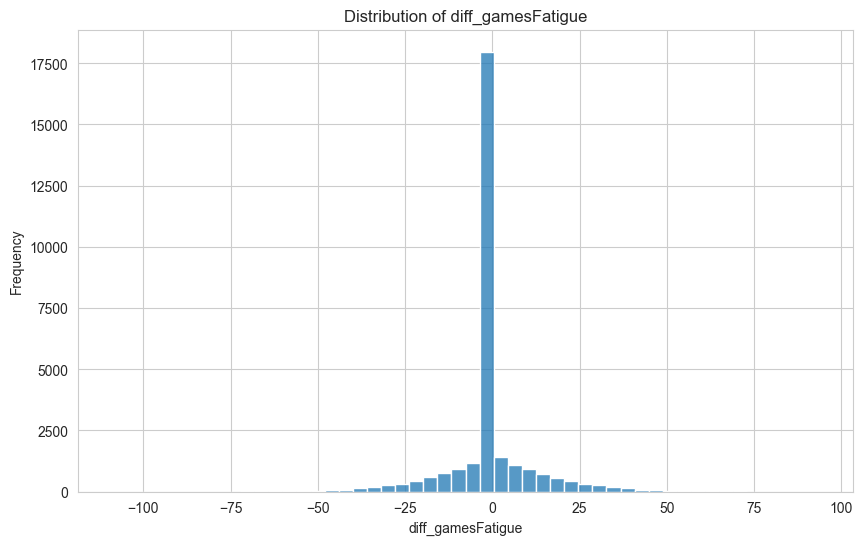

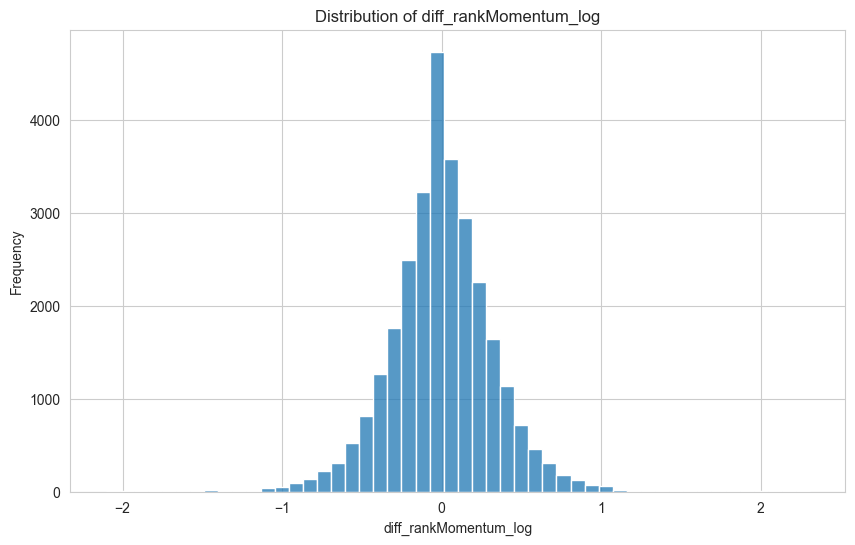

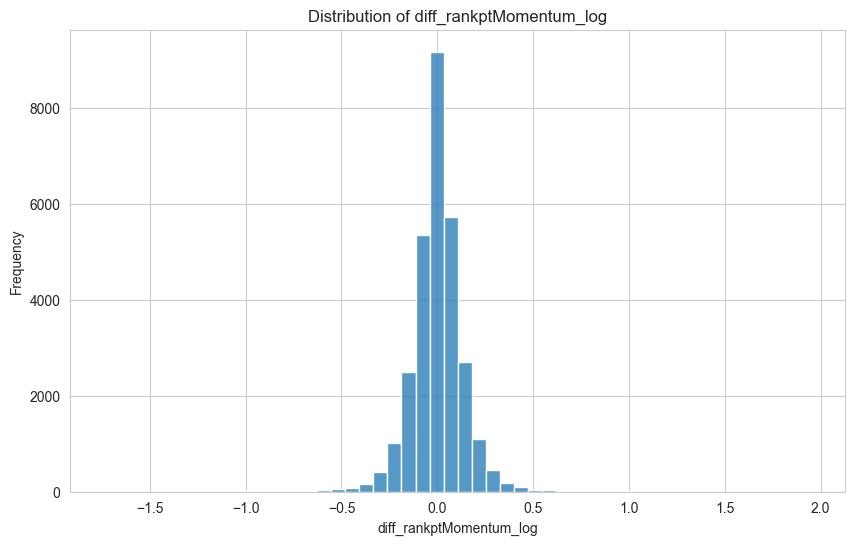

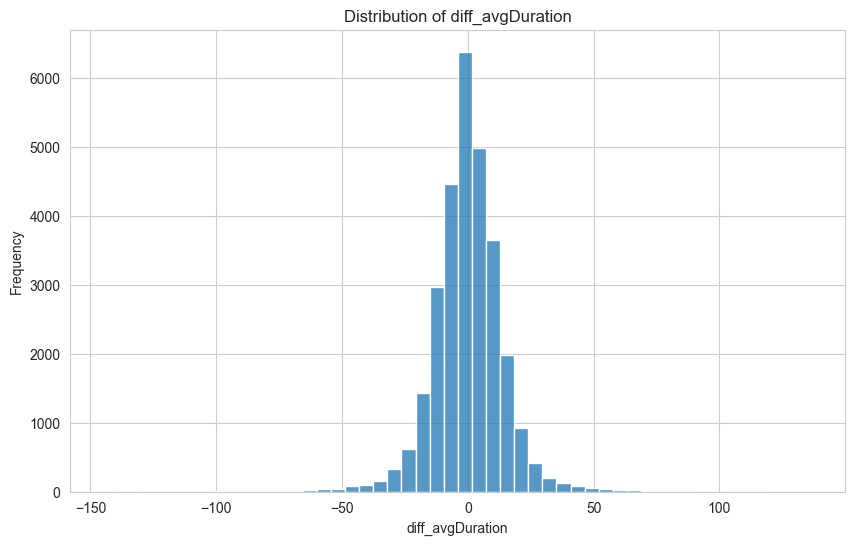

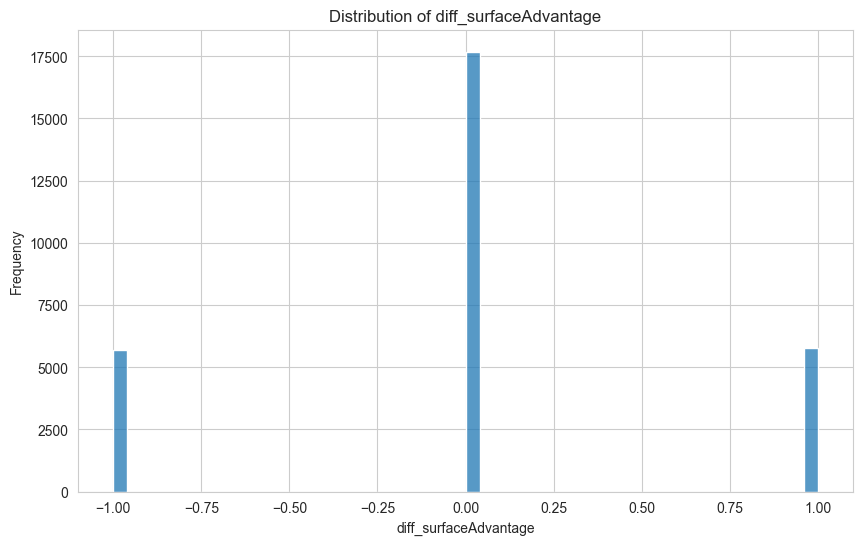

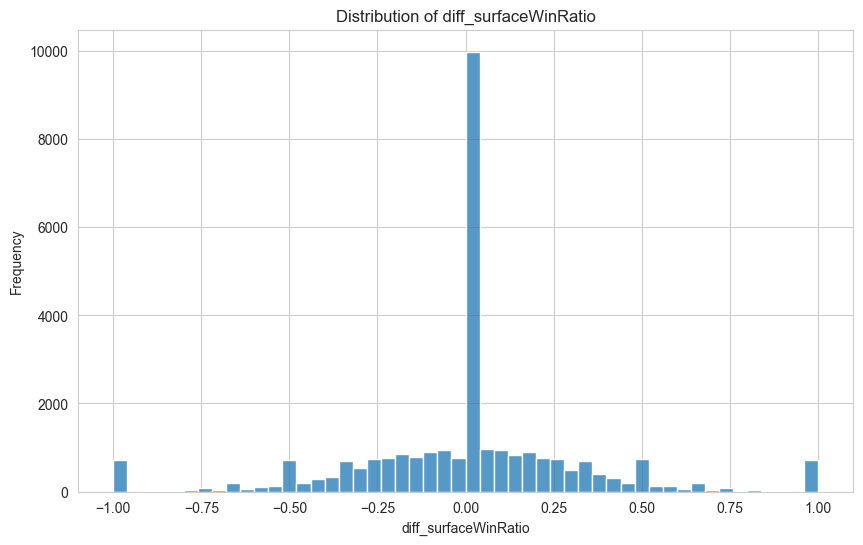

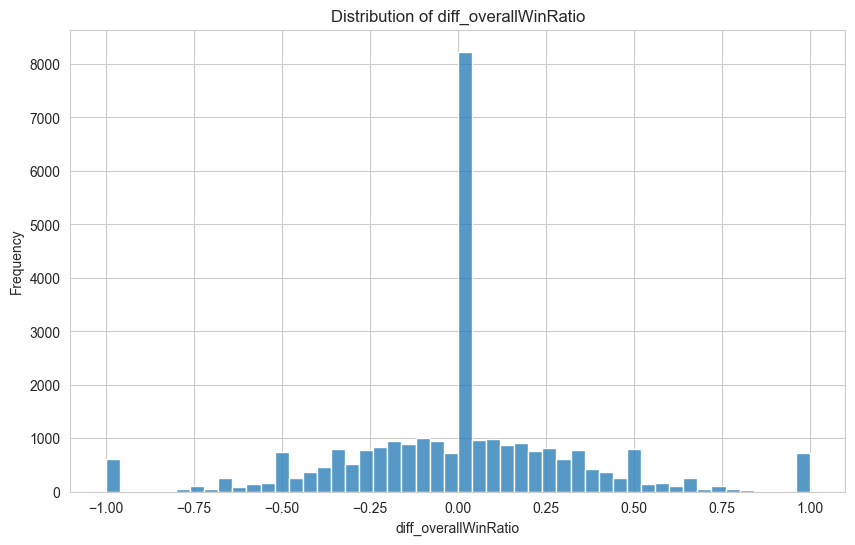

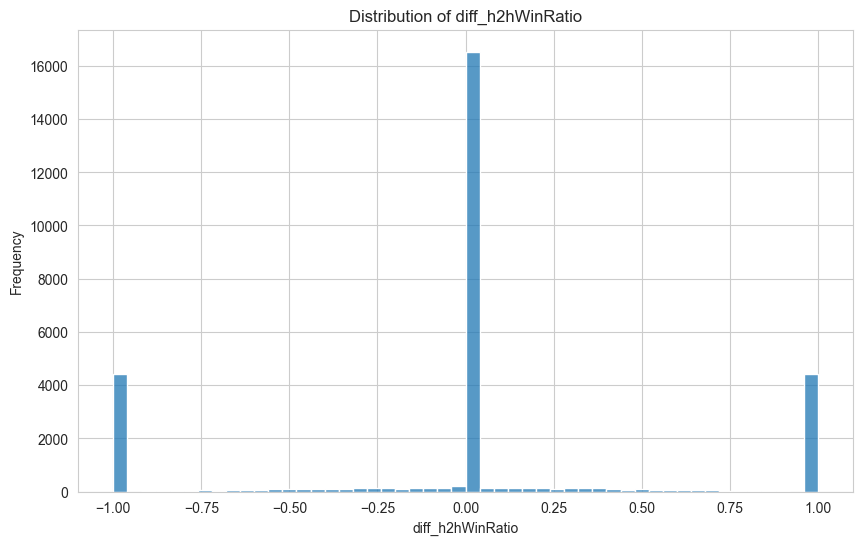

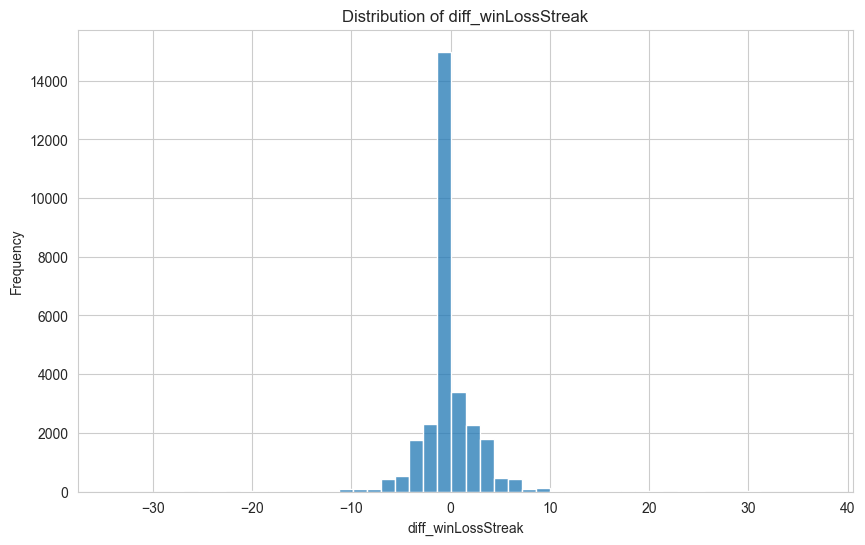

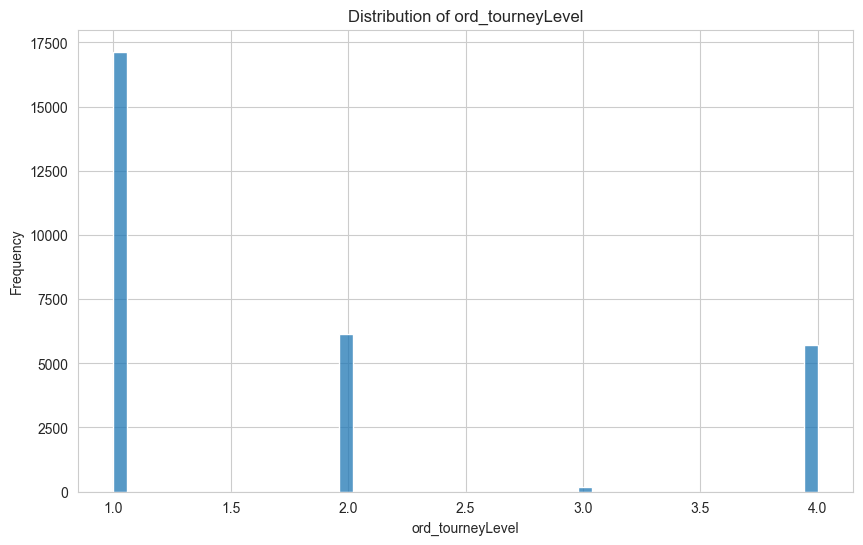

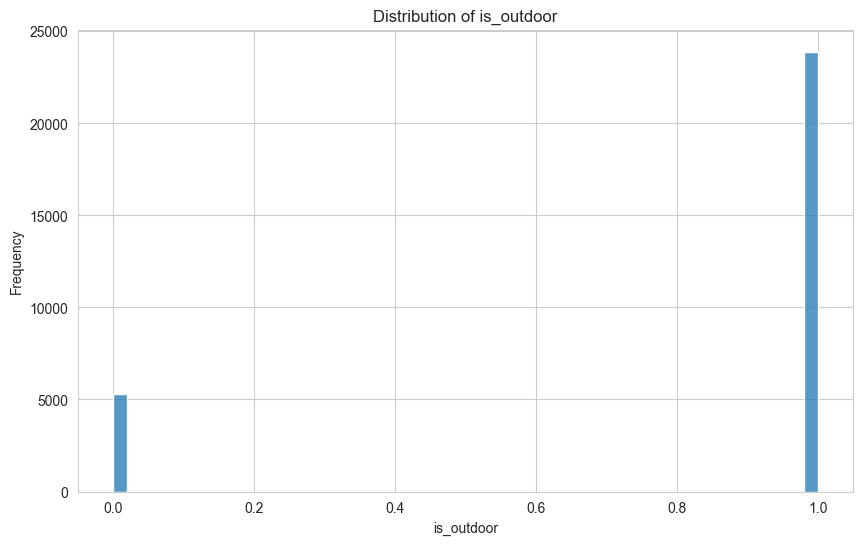

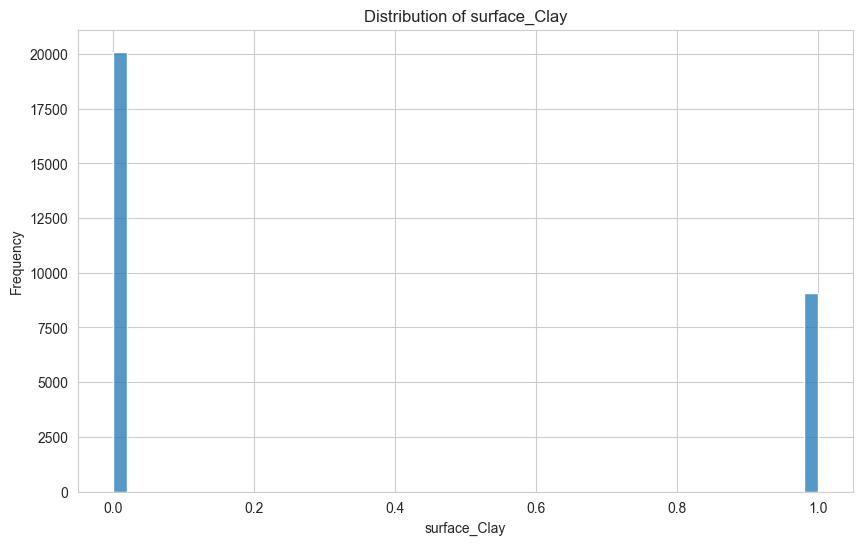

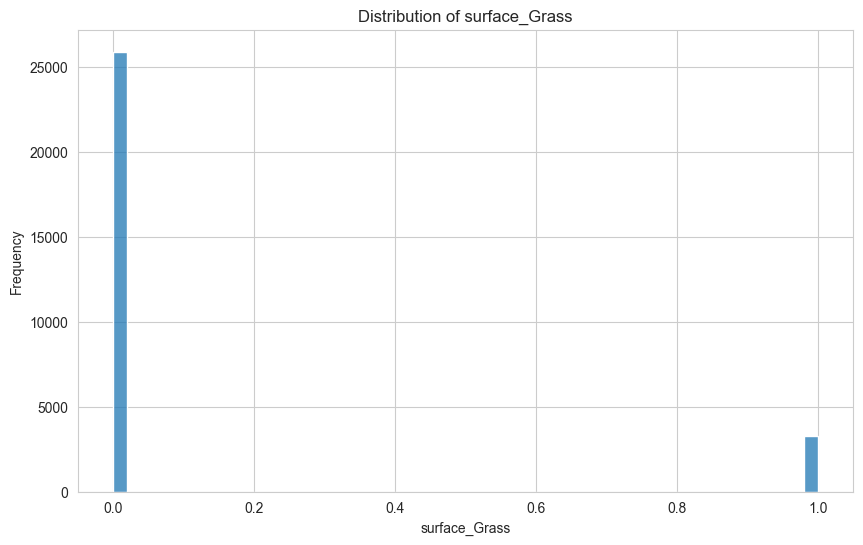

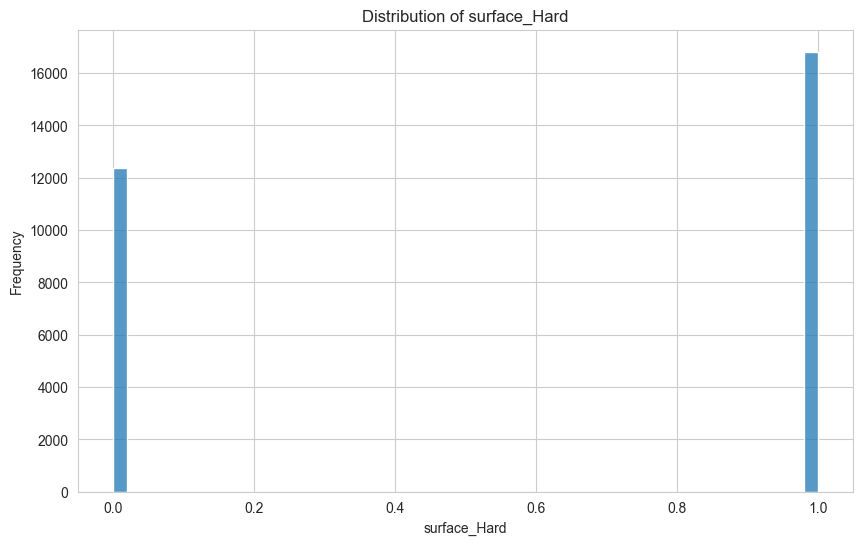

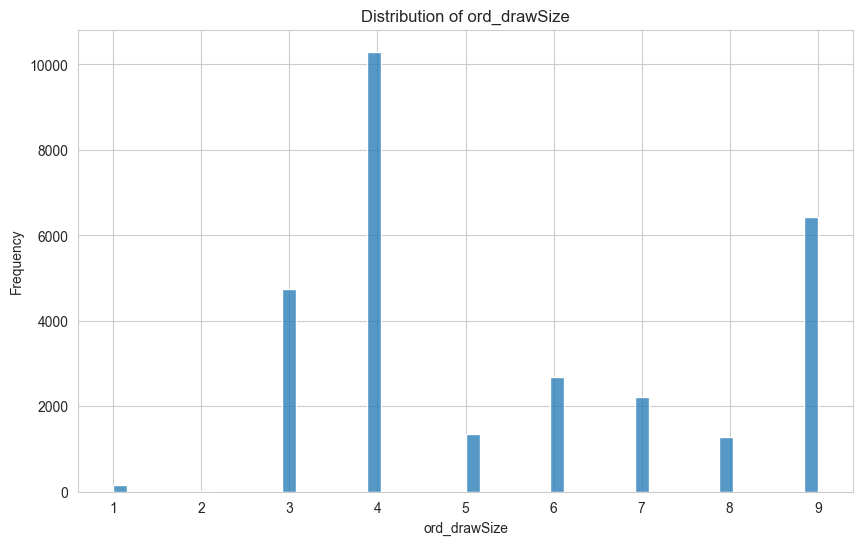

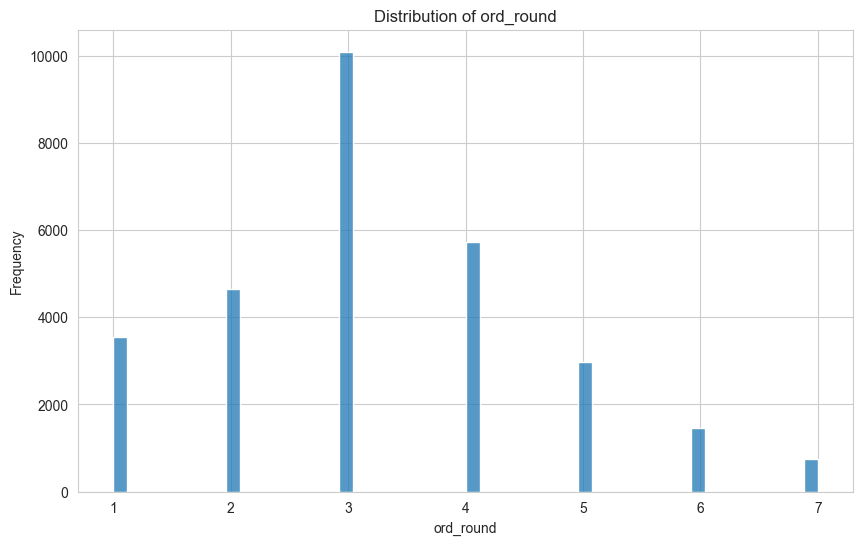

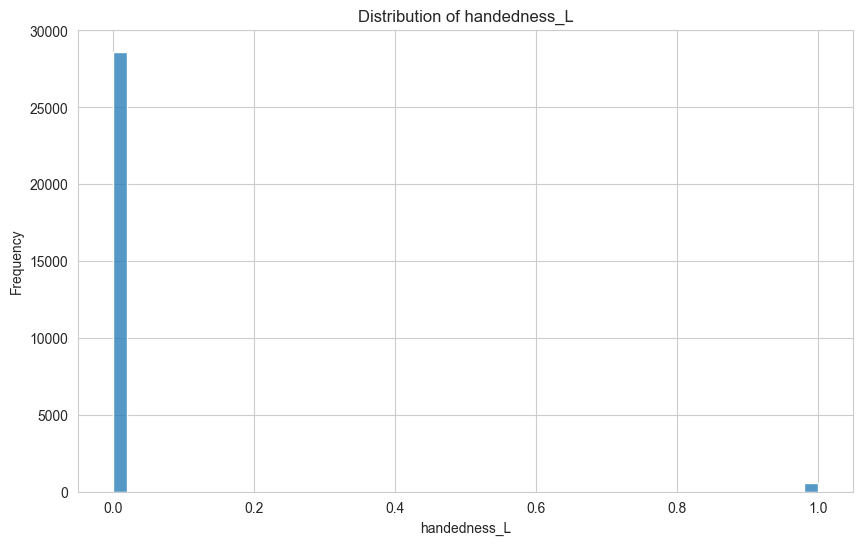

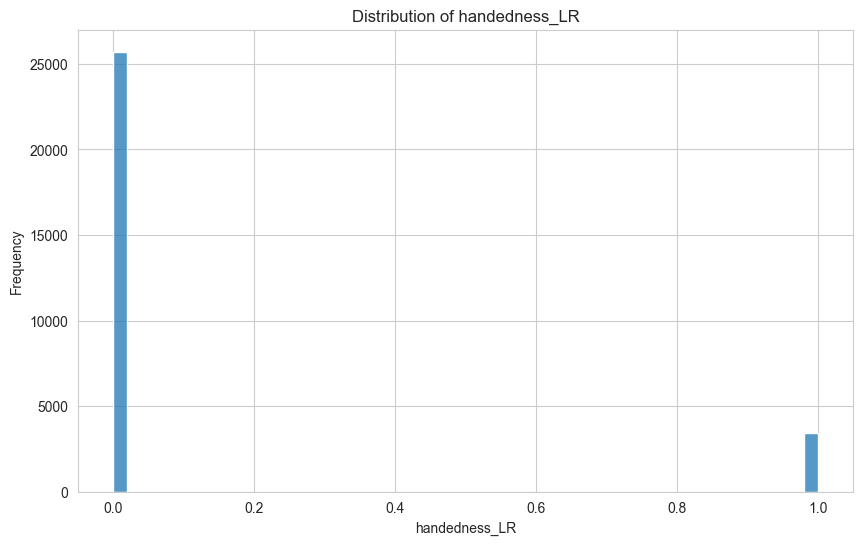

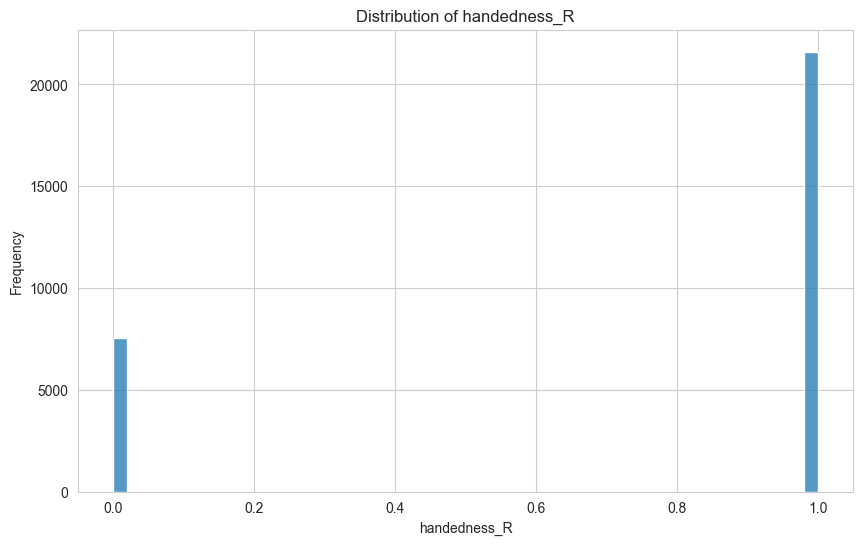

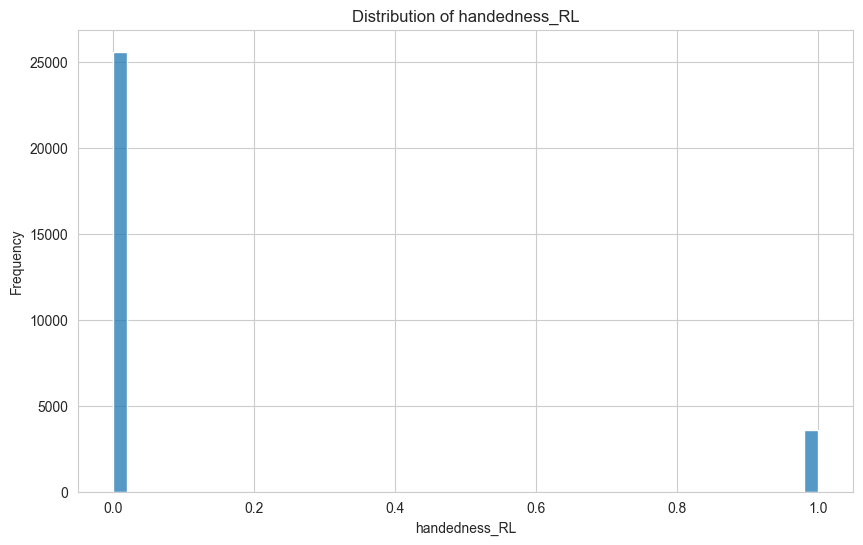

In [8]:
# Visualize the distribution of the feature columns
def plot_histogram(column, bins=50, kde=False):
    plt.figure(figsize=(10, 6))
    sns.histplot(column, bins=bins, kde=kde)
    plt.title(f'Distribution of {column.name}')
    plt.xlabel(column.name)
    plt.ylabel('Frequency')
    plt.show()

for col in X_train.columns:
    plot_histogram(X_train[col])

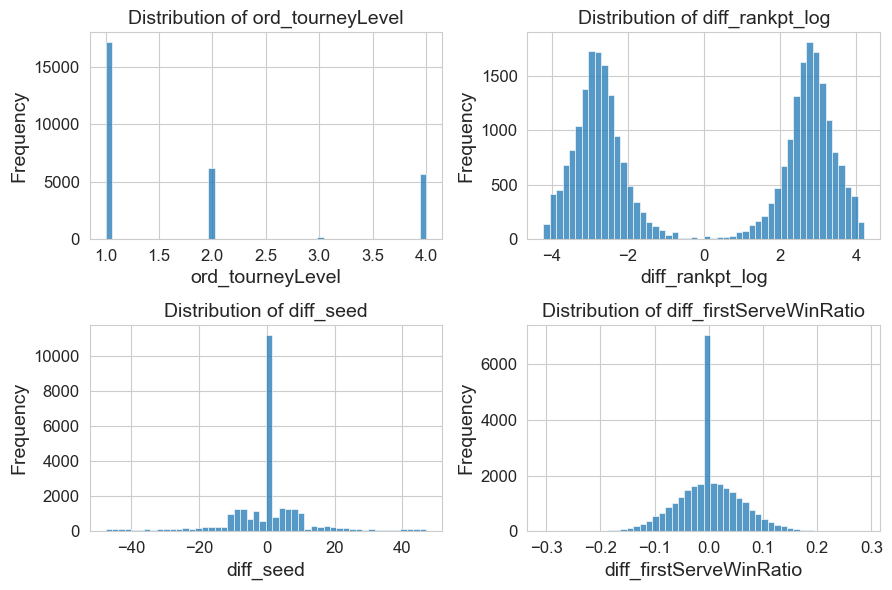

In [9]:
# Define the list of features to plot
features_to_plot = ['ord_tourneyLevel', 'diff_rankpt_log', 'diff_seed', 'diff_firstServeWinRatio']

# Initialize the plot
fig, axes = plt.subplots(2, 2, figsize=(9, 6))

# Loop through each feature and its corresponding subplot
for i, feature in enumerate(features_to_plot):
    row = i // 2
    col = i % 2
    ax = axes[row, col]
    
    # Plot the histogram
    # Plot the histogram
    sns.histplot(X_train[feature], bins=50, kde=False, ax=ax)
    ax.set_title(f'Distribution of {feature}', fontsize=14)  # Increase font size for title
    ax.set_xlabel(feature, fontsize=14)  # Increase font size for x-axis label
    ax.set_ylabel('Frequency', fontsize=14)  # Increase font size for y-axis label
    ax.tick_params(axis='both', which='major', labelsize=12)  # Increase font size for ticks

plt.tight_layout()
plt.show()

In [10]:
# Define different types of features
normal_cols = ['diff_firstServeInRatio', 'diff_firstServeWinRatio', 'diff_secondServeWinRatio',
                'diff_overallServeWinRatio', 'diff_overallReturnWinRatio', 
                'diff_completeness', 
                'diff_acePerServePoint', 'diff_dfPerServePoint', 
                'diff_acePerServeGame', 'diff_dfPerServeGame',
                'diff_bpSaveRatio', 
                'diff_ht', 'diff_age', 'diff_agePersonalPeak', 'diff_ageGeneralPeak',
                'diff_rankMomentum_log', 'diff_rankptMomentum_log',
                'diff_avgDuration']
bimodal_cols = ['diff_Avg_implied', 'diff_rank_log', 'diff_rankpt_log']
spike_cols = ['diff_rank', 'diff_rankpt', 
              'diff_homeAdvantage', 'diff_seed', 'diff_gamesFatigue', 
              'diff_surfaceAdvantage', 'diff_surfaceWinRatio', 'diff_overallWinRatio', 
              'diff_h2hWinRatio', 'diff_winLossStreak']
ordinal_cols = ['ord_tourneyLevel', 'ord_drawSize', 'ord_round']
binary_cols = ['is_grandSlam', 'is_formerTop10', 'is_outdoor', 
               'surface_Clay', 'surface_Grass', 'surface_Hard', 
               'handedness_L', 'handedness_LR', 'handedness_R', 'handedness_RL',
               'year'] # in order to leave 'year' unscaled

diff_firstServeInRatio  diff_firstServeWinRatio  diff_secondServeWinRatio  diff_overallServeWinRatio  diff_overallReturnWinRatio  diff_completeness  diff_acePerServePoint  diff_dfPerServePoint  \
min          -0.30                   -0.30                     -0.30                     -0.24                       -0.26                  -0.13                -0.23                  -0.09           
max           0.26                    0.29                      0.31                      0.22                        0.31                   0.16                 0.25                   0.08           

     diff_acePerServeGame  diff_dfPerServeGame  diff_bpSaveRatio  diff_ht  diff_age  diff_agePersonalPeak  diff_ageGeneralPeak  diff_rankMomentum_log  diff_rankptMomentum_log  diff_avgDuration  \
min         -1.38                -0.57               -0.59        -41.00    -25.90          -11.70               -16.10                -2.11                   -1.73                -144.00        
max          1.49                 0.59                0.54         41.00     21.70           11.60                13.20                 2.31                    1.95                 135.99        

     diff_Avg_implied  diff_rank_log  diff_rankpt_log  diff_rank  diff_rankpt  diff_homeAdvantage  diff_seed  diff_gamesFatigue  diff_surfaceAdvantage  diff_surfaceWinRatio  diff_overallWinRatio  \
min       -0.97           -3.34           -4.22        -2194.00   -16641.00          -1.00          -47.50        -108.64               -1.00                  -1.00                 -1.00           
max        0.97            3.34            4.21         2191.00    16143.00           1.00           47.00          93.22                1.00                   1.00                  1.00           

     diff_h2hWinRatio  diff_winLossStreak  ord_tourneyLevel  ord_drawSize  ord_round  is_grandSlam  is_formerTop10  is_outdoor  surface_Clay  surface_Grass  surface_Hard  handedness_L  \
min       -1.00              -34.00              1.00            1.00        1.00         0.00           0.00          0.00         0.00          0.00           0.00          0.00       
max        1.00               37.00              4.00            9.00        7.00         1.00           1.00          1.00         1.00          1.00           1.00          1.00       

     handedness_LR  handedness_R  handedness_RL   year   
min      0.00           0.00          0.00      2009.00  
max      1.00           1.00          1.00      2020.00

diff_firstServeInRatio  diff_firstServeWinRatio  diff_secondServeWinRatio  diff_overallServeWinRatio  diff_overallReturnWinRatio  diff_completeness  diff_acePerServePoint  diff_dfPerServePoint  \
min          -0.27                   -0.29                     -0.26                     -0.17                       -0.25                  -0.10                -0.23                  -0.08           
max           0.24                    0.22                      0.26                      0.18                        0.18                   0.14                 0.23                   0.09           

     diff_acePerServeGame  diff_dfPerServeGame  diff_bpSaveRatio  diff_ht  diff_age  diff_agePersonalPeak  diff_ageGeneralPeak  diff_rankMomentum_log  diff_rankptMomentum_log  diff_avgDuration  \
min         -1.37                -0.62               -0.49        -33.00    -21.60          -11.80               -13.20                -1.43                   -0.76                 -94.01        
max          1.38                 0.60                0.47         36.00     18.70           11.90                15.10                 1.84                    1.68                 151.16        

     diff_Avg_implied  diff_rank_log  diff_rankpt_log  diff_rank  diff_rankpt  diff_homeAdvantage  diff_seed  diff_gamesFatigue  diff_surfaceAdvantage  diff_surfaceWinRatio  diff_overallWinRatio  \
min       -0.94           -3.34           -4.06        -2170.00   -11360.00          -1.00          -47.00         -69.63               -1.00                  -1.00                 -1.00           
max        0.93            3.33            4.07         2155.00    11858.00           1.00           47.00          72.08                1.00                   1.00                  1.00           

     diff_h2hWinRatio  diff_winLossStreak  ord_tourneyLevel  ord_drawSize  ord_round  is_grandSlam  is_formerTop10  is_outdoor  surface_Clay  surface_Grass  surface_Hard  handedness_L  \
min       -1.00              -18.00              1.00            1.00        1.00         0.00           0.00          0.00         0.00          0.00           0.00          0.00       
max        1.00               18.00              4.00            9.00        7.00         1.00           1.00          1.00         1.00          1.00           1.00          1.00       

     handedness_LR  handedness_R  handedness_RL   year   
min      0.00           0.00          0.00      2021.00  
max      1.00           1.00          1.00      2022.00

diff_firstServeInRatio  diff_firstServeWinRatio  diff_secondServeWinRatio  diff_overallServeWinRatio  diff_overallReturnWinRatio  diff_completeness  diff_acePerServePoint  diff_dfPerServePoint  \
min          -5.24                   -5.20                     -6.23                     -5.24                       -5.97                  -6.52                -4.16                  -6.19           
max           4.54                    4.86                      6.35                      4.60                        7.19                   7.64                 4.40                   5.61           

     diff_acePerServeGame  diff_dfPerServeGame  diff_bpSaveRatio  diff_ht  diff_age  diff_agePersonalPeak  diff_ageGeneralPeak  diff_rankMomentum_log  diff_rankptMomentum_log  diff_avgDuration  \
min         -4.17                -5.70               -7.17        -4.18     -4.66           -3.67                -5.01                 -6.67                   -12.51                -10.34        
max          4.47                 5.95                6.61         4.16      3.91            3.64                 4.10                  7.30                    14.05                  9.77        

     diff_Avg_implied  diff_rank_log  diff_rankpt_log  diff_rank  diff_rankpt  diff_homeAdvantage  diff_seed  diff_gamesFatigue  diff_surfaceAdvantage  diff_surfaceWinRatio  diff_overallWinRatio  \
min       -2.16           -2.03           -1.48         -13.03      -6.27            -2.10          -3.47          -8.98                -1.60                  -3.03                 -2.93           
max        2.15            2.04            1.47          13.02       6.09             2.10           3.43           7.70                 1.59                   3.02                  2.90           

     diff_h2hWinRatio  diff_winLossStreak  ord_tourneyLevel  ord_drawSize  ord_round  is_grandSlam  is_formerTop10  is_outdoor  surface_Clay  surface_Grass  surface_Hard  handedness_L  \
min       -1.76              -11.61              0.00            0.00        0.00         0.00           0.00          0.00         0.00          0.00           0.00          0.00       
max        1.76               12.63              1.00            1.00        1.00         1.00           1.00          1.00         1.00          1.00           1.00          1.00       

     handedness_LR  handedness_R  handedness_RL   year   
min      0.00           0.00          0.00      2009.00  
max      1.00           1.00          1.00      2020.00

diff_firstServeInRatio  diff_firstServeWinRatio  diff_secondServeWinRatio  diff_overallServeWinRatio  diff_overallReturnWinRatio  diff_completeness  diff_acePerServePoint  diff_dfPerServePoint  \
min          -4.70                   -4.93                     -5.32                     -3.71                       -5.83                  -5.07                -4.22                  -5.81           
max           4.21                    3.65                      5.32                      3.86                        4.15                   7.02                 4.20                   6.44           

     diff_acePerServeGame  diff_dfPerServeGame  diff_bpSaveRatio  diff_ht  diff_age  diff_agePersonalPeak  diff_ageGeneralPeak  diff_rankMomentum_log  diff_rankptMomentum_log  diff_avgDuration  \
min         -4.14                -6.21               -6.02        -3.37     -3.88           -3.70                -4.11                 -4.53                   -5.48                 -6.75         
max          4.13                 6.06                5.81         3.66      3.37            3.73                 4.70                  5.81                   12.14                 10.85         

     diff_Avg_implied  diff_rank_log  diff_rankpt_log  diff_rank  diff_rankpt  diff_homeAdvantage  diff_seed  diff_gamesFatigue  diff_surfaceAdvantage  diff_surfaceWinRatio  diff_overallWinRatio  \
min       -2.10           -2.03           -1.42         -12.89      -4.28            -2.10          -3.43          -5.75                -1.60                  -3.03                 -2.93           
max        2.07            2.04            1.42          12.81       4.47             2.10           3.43           5.95                 1.59                   3.02                  2.90           

     diff_h2hWinRatio  diff_winLossStreak  ord_tourneyLevel  ord_drawSize  ord_round  is_grandSlam  is_formerTop10  is_outdoor  surface_Clay  surface_Grass  surface_Hard  handedness_L  \
min       -1.76              -6.14               0.00            0.00        0.00         0.00           0.00          0.00         0.00          0.00           0.00          0.00       
max        1.76               6.15               1.00            1.00        1.00         1.00           1.00          1.00         1.00          1.00           1.00          1.00       

     handedness_LR  handedness_R  handedness_RL   year   
min      0.00           0.00          0.00      2021.00  
max      1.00           1.00          1.00      2022.00

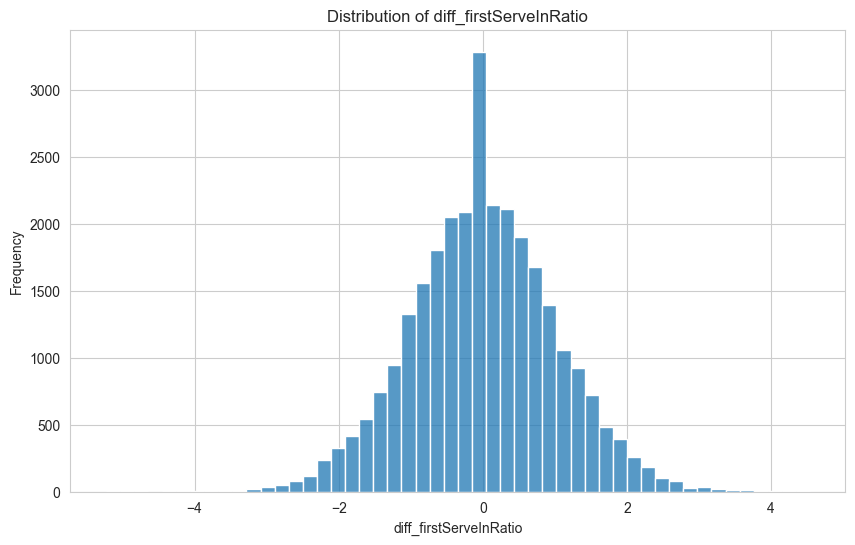

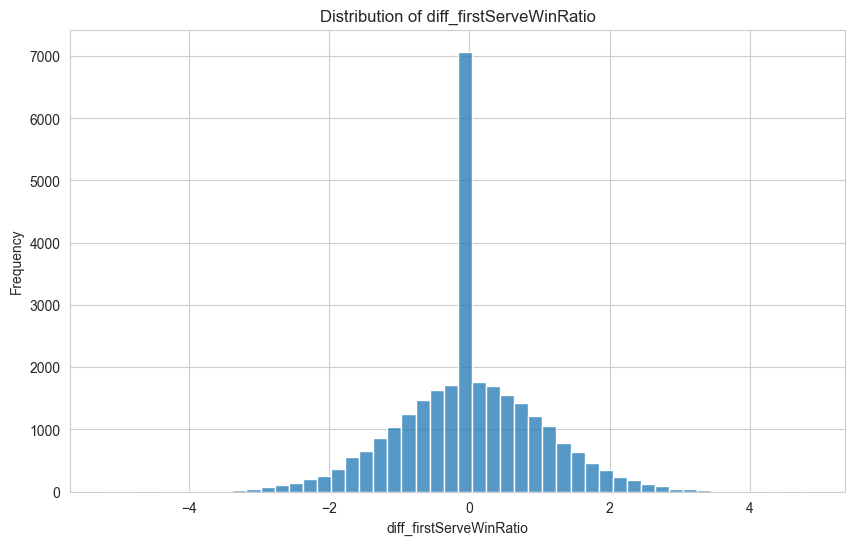

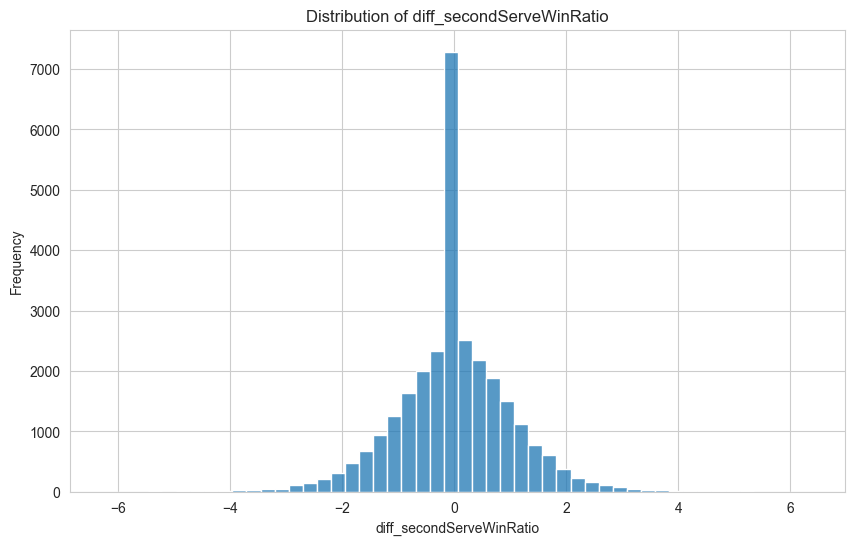

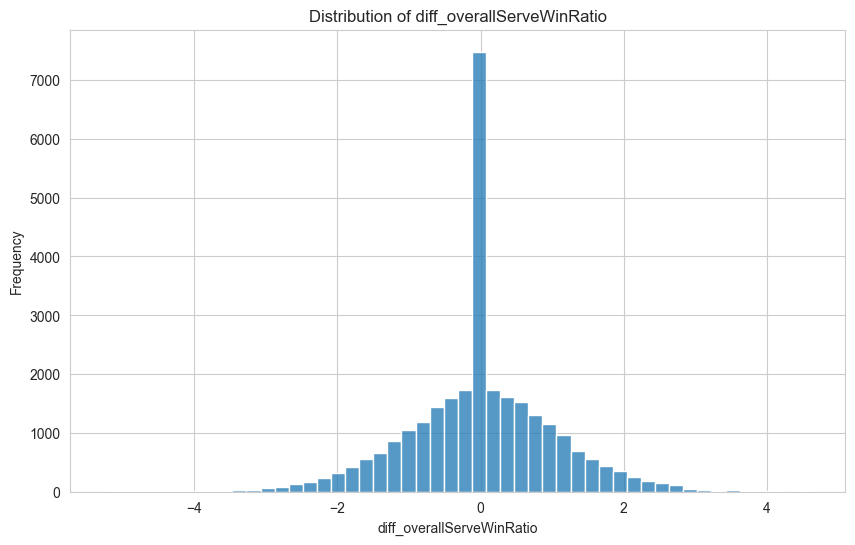

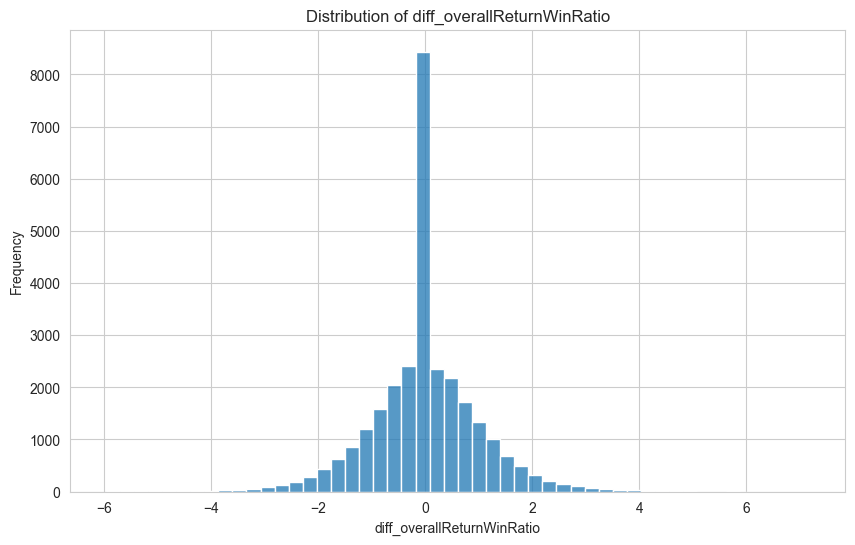

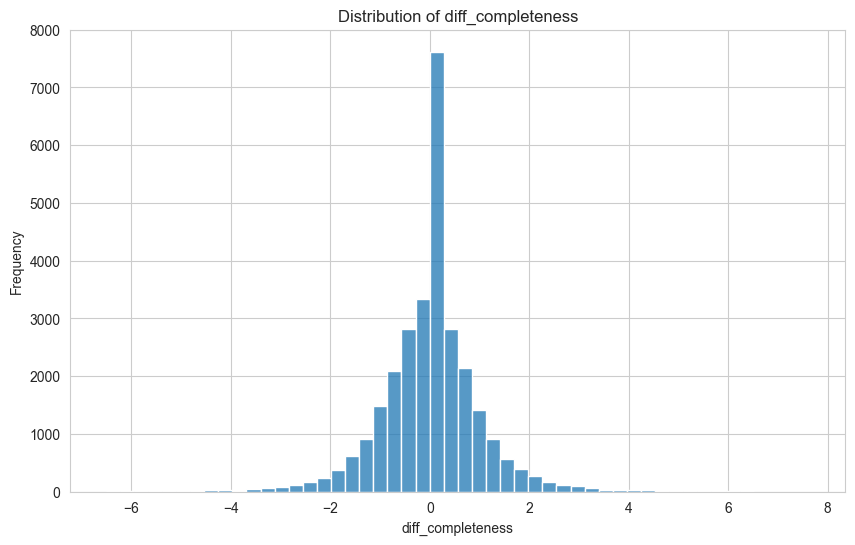

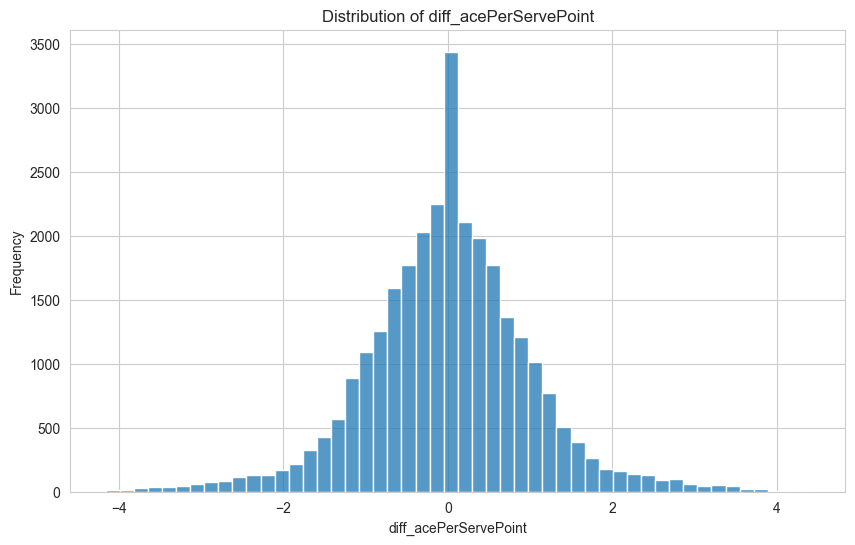

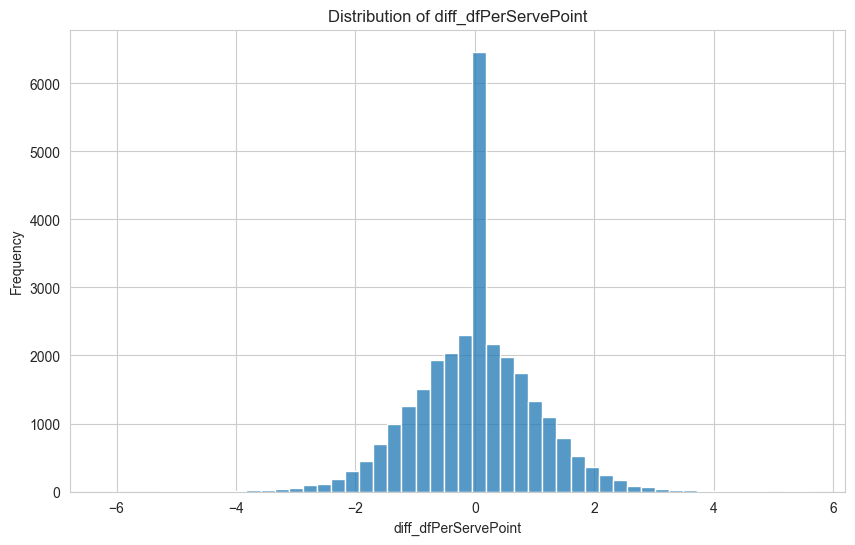

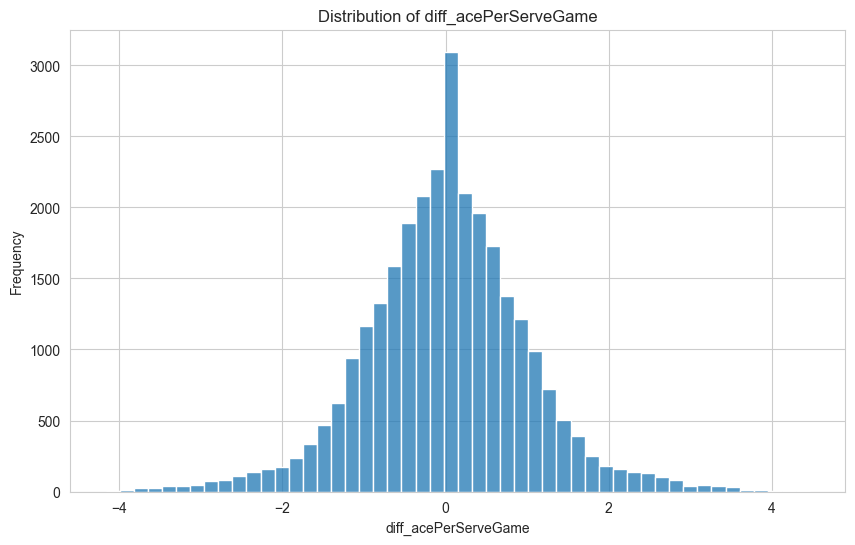

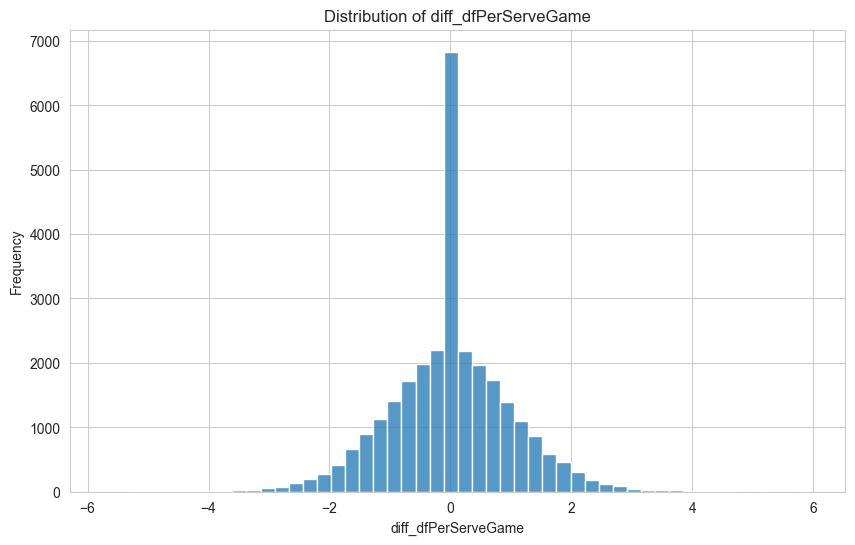

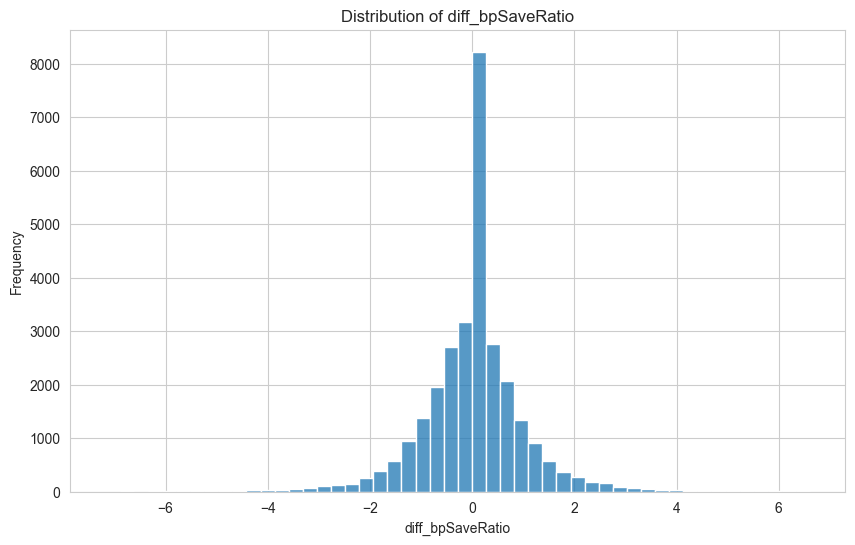

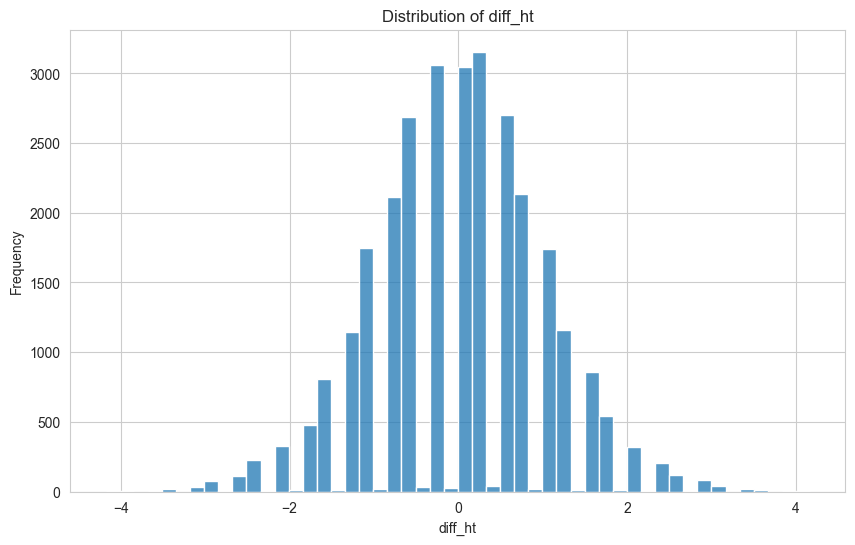

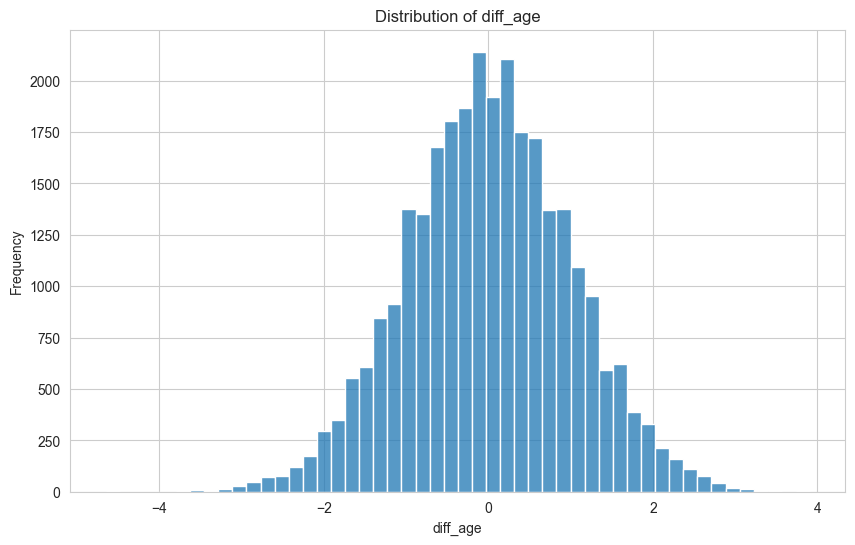

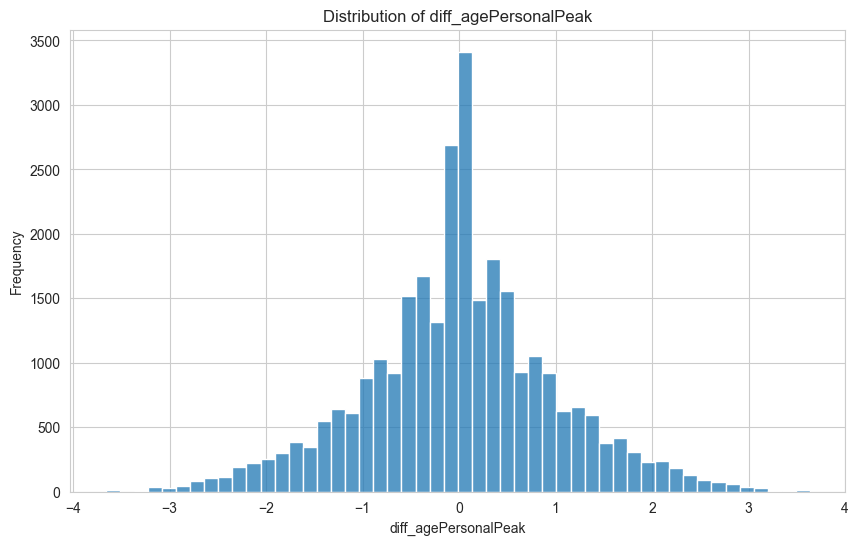

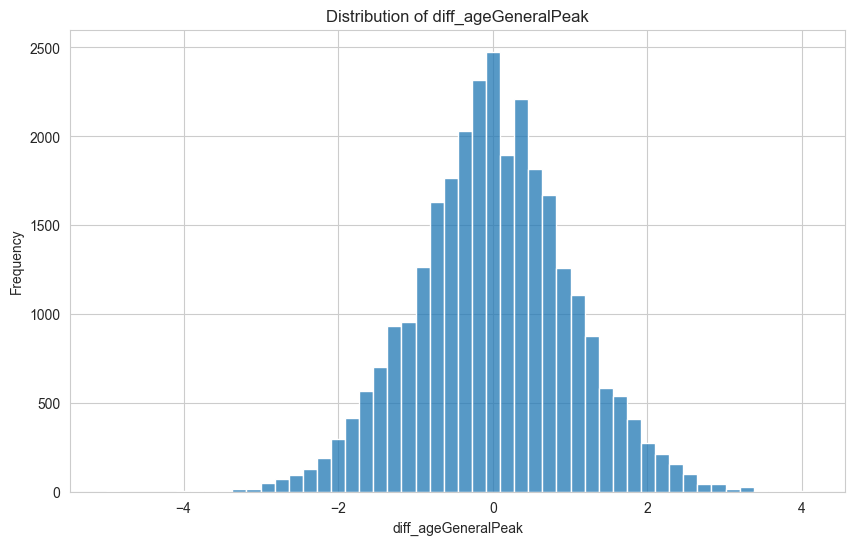

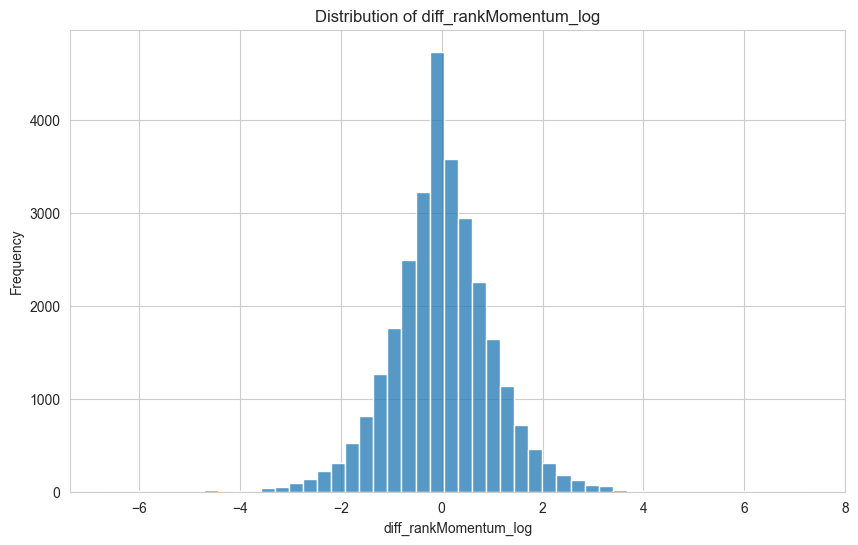

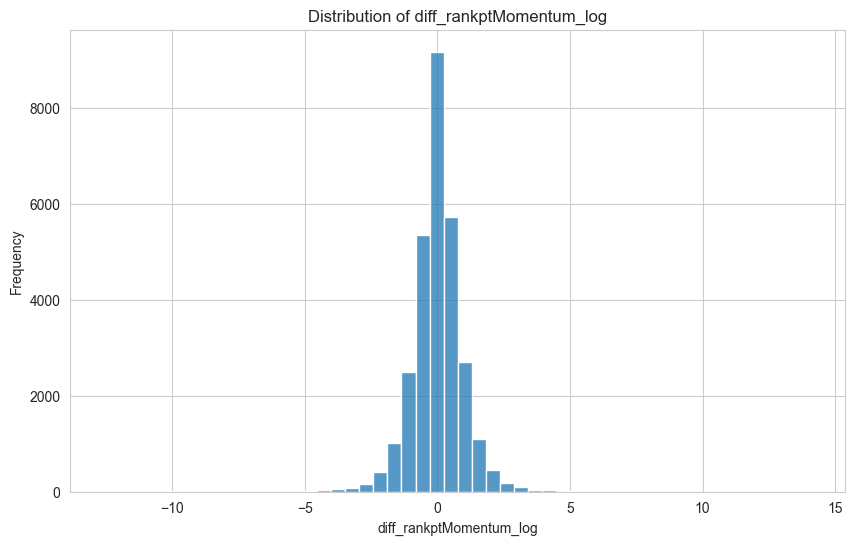

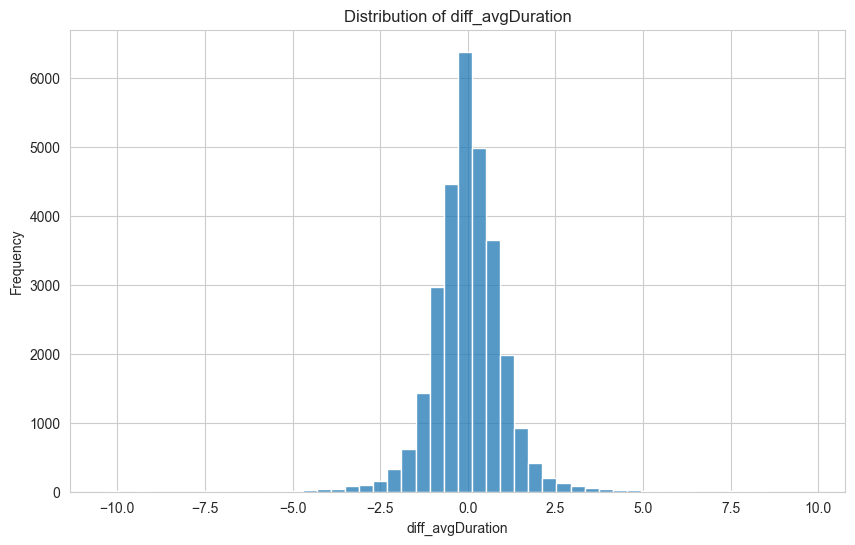

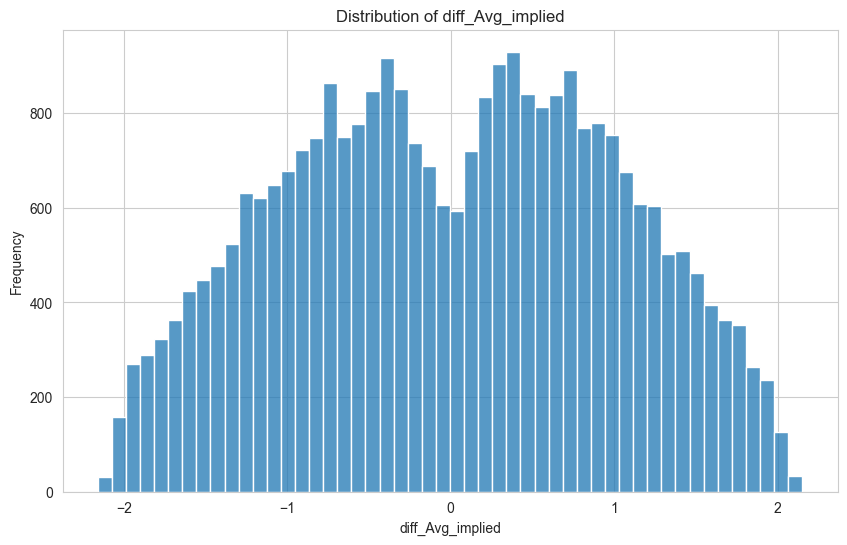

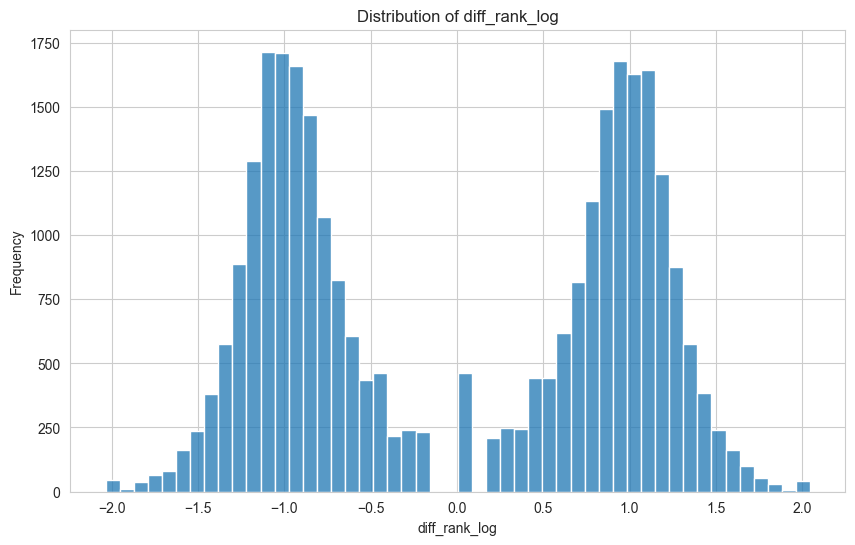

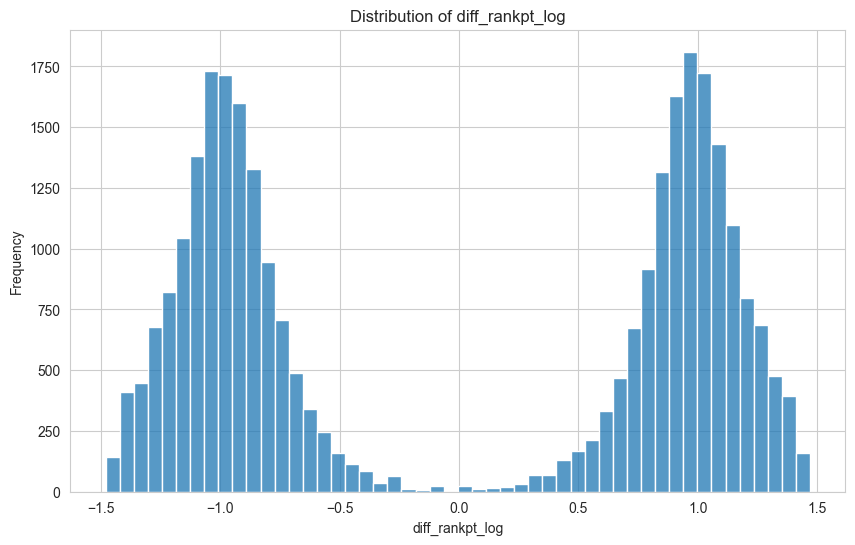

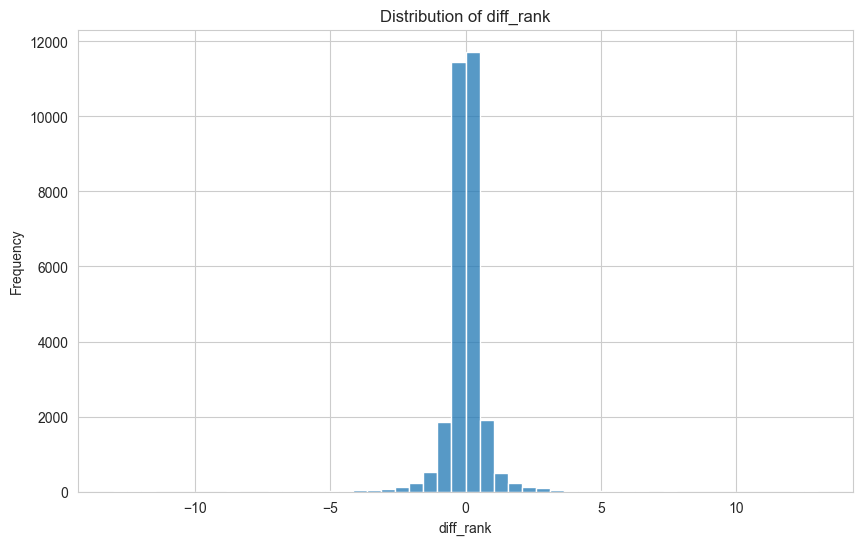

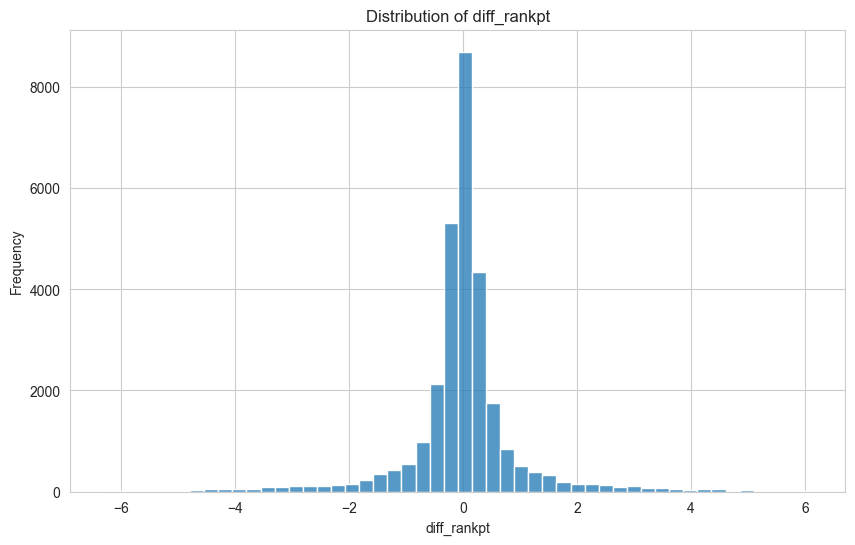

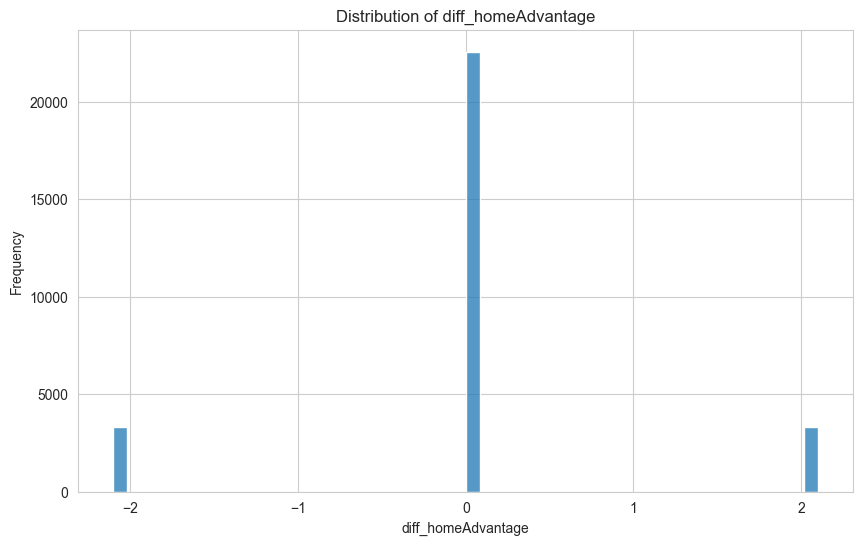

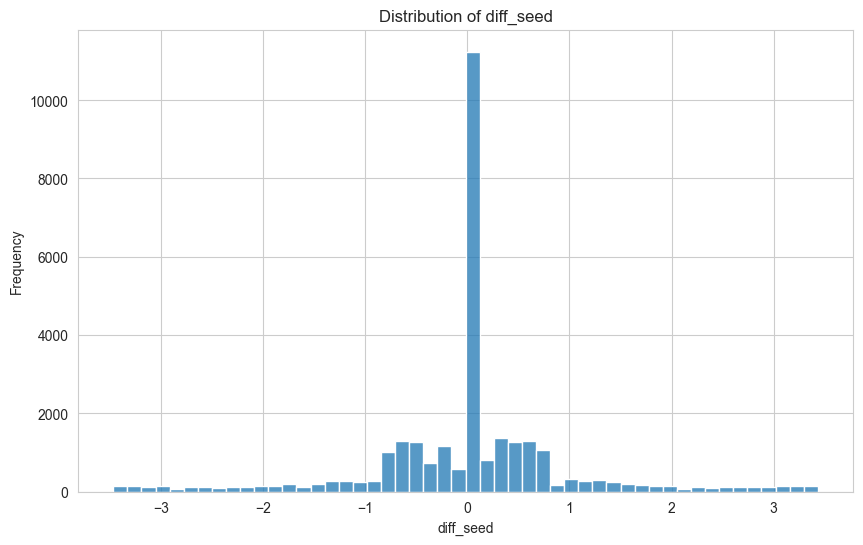

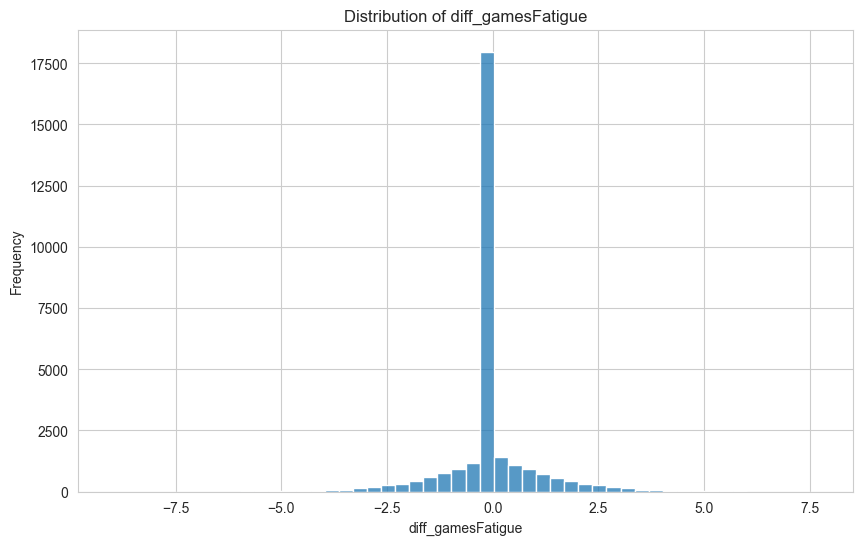

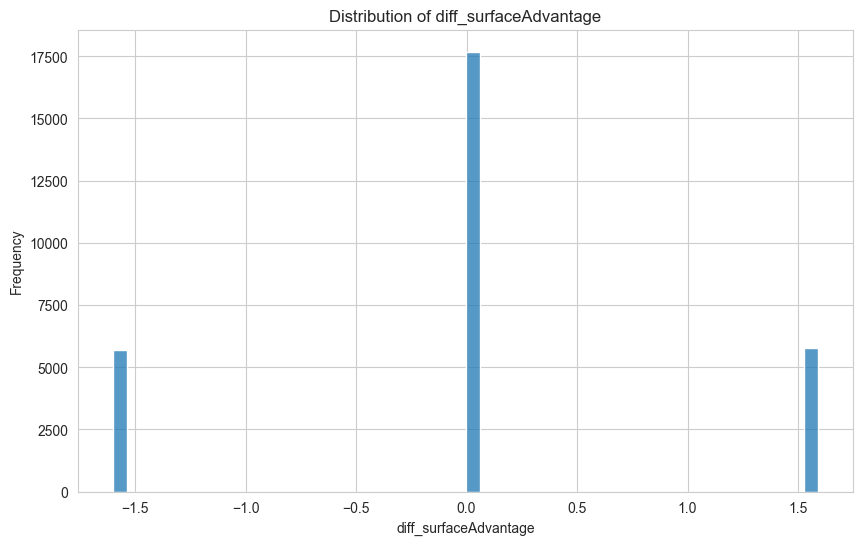

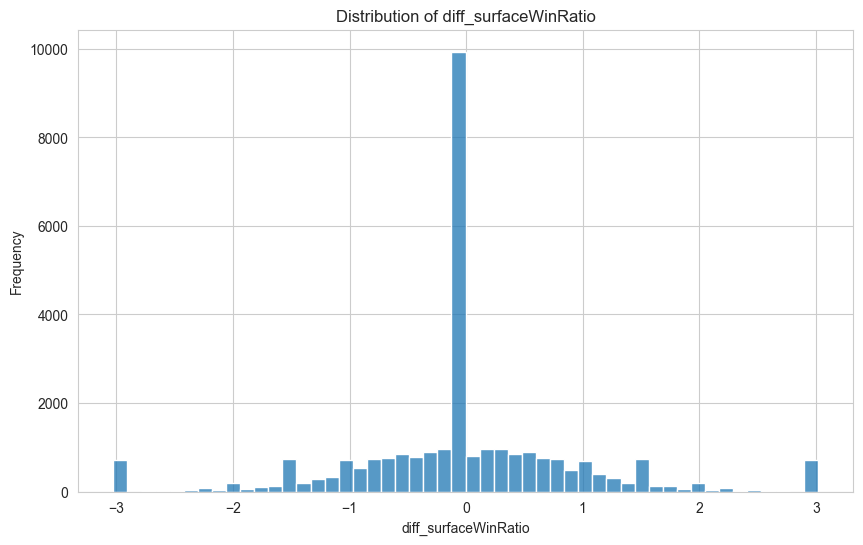

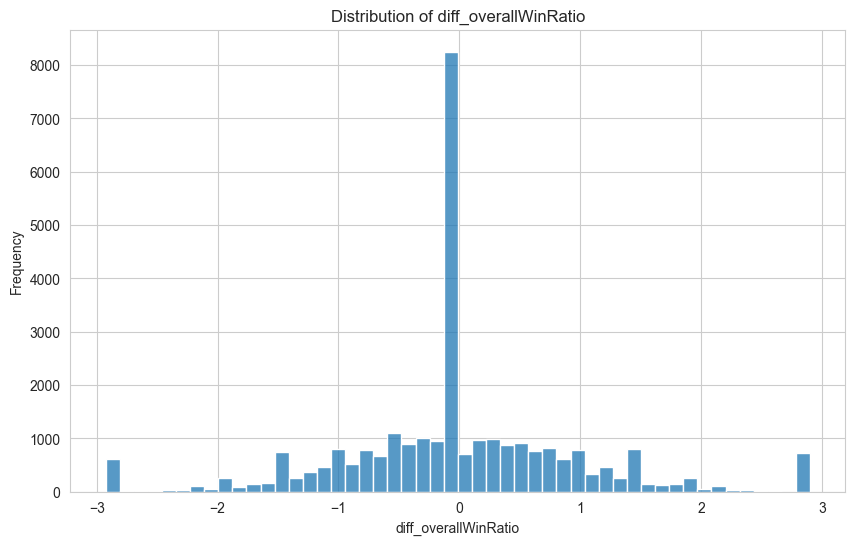

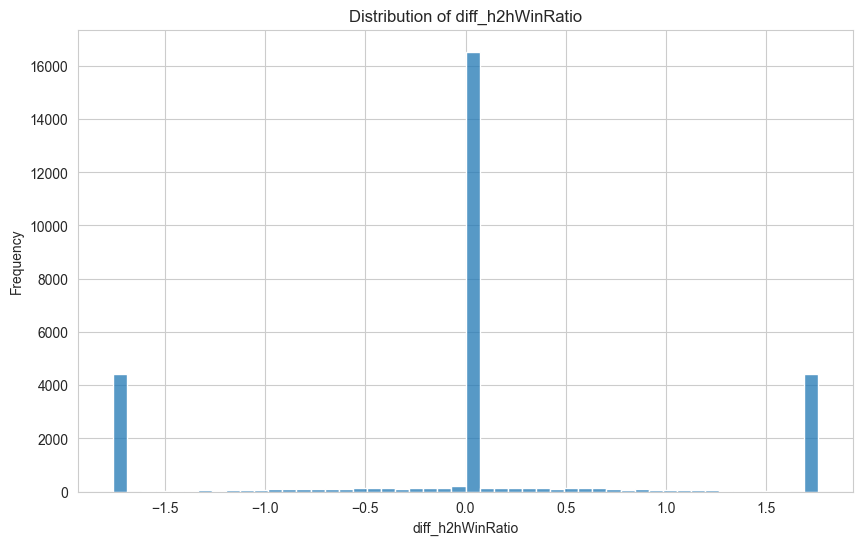

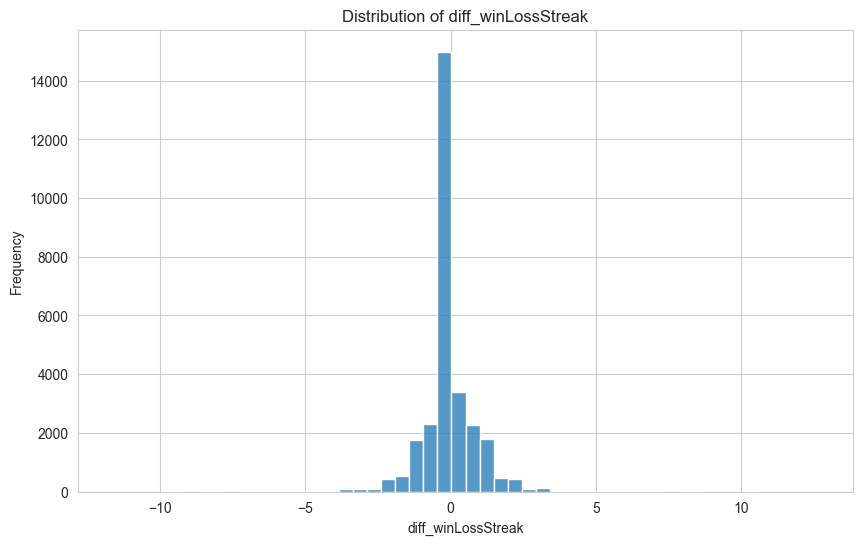

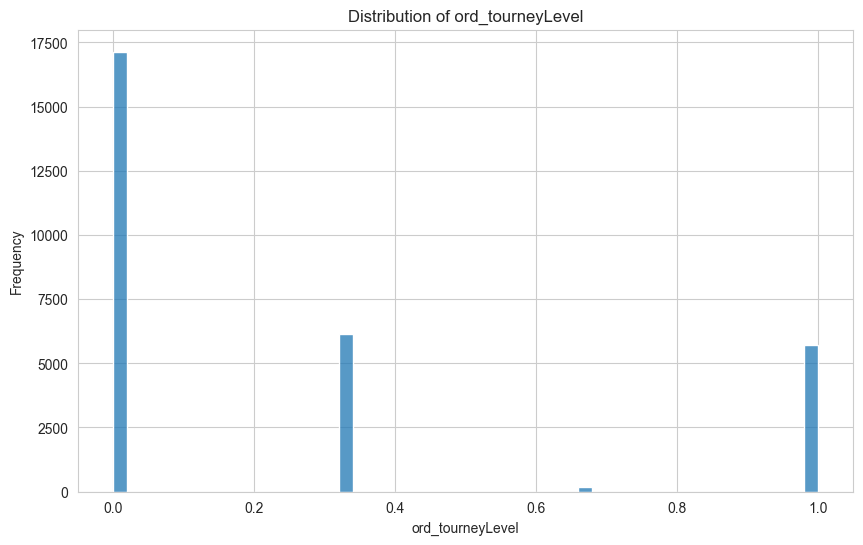

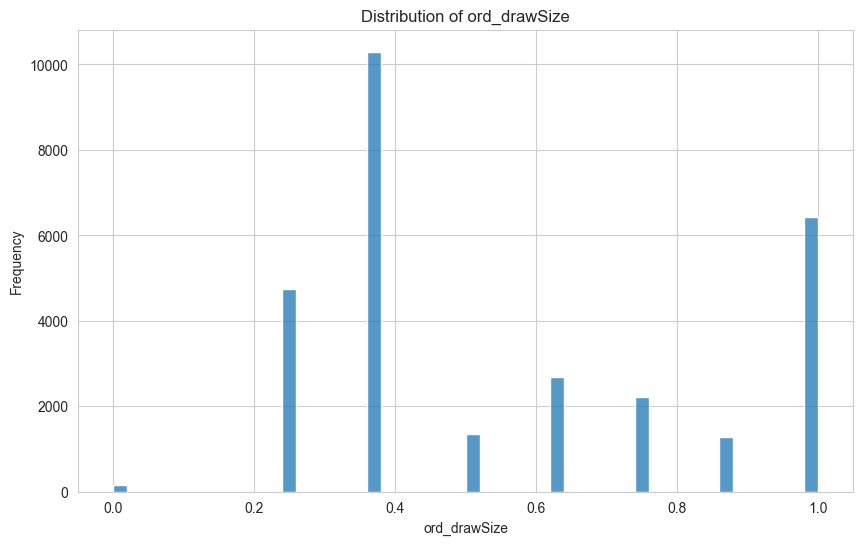

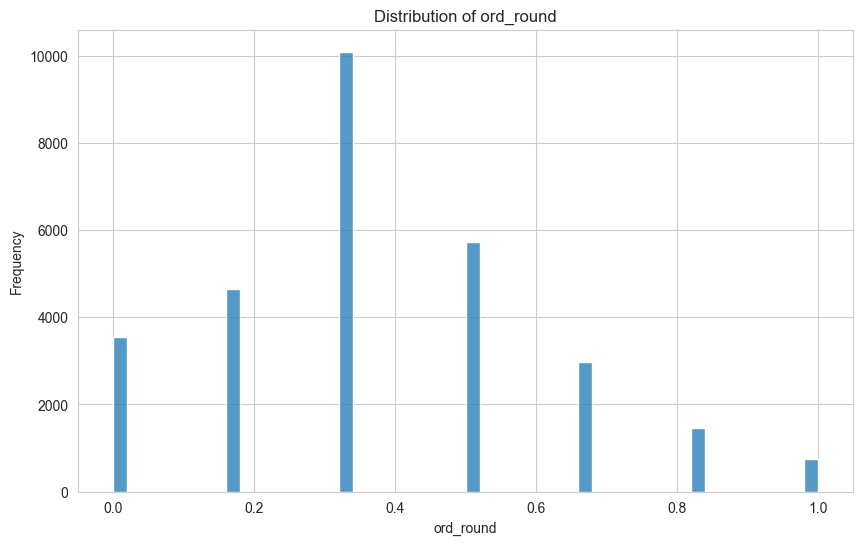

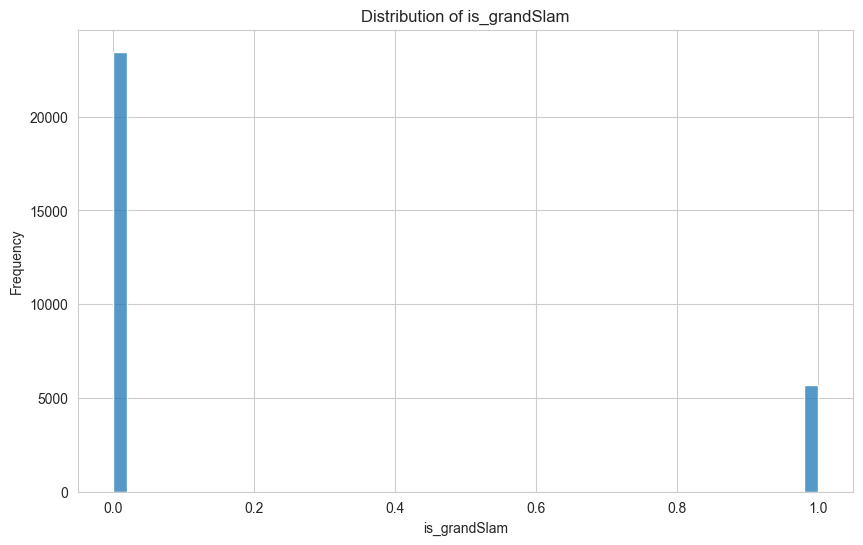

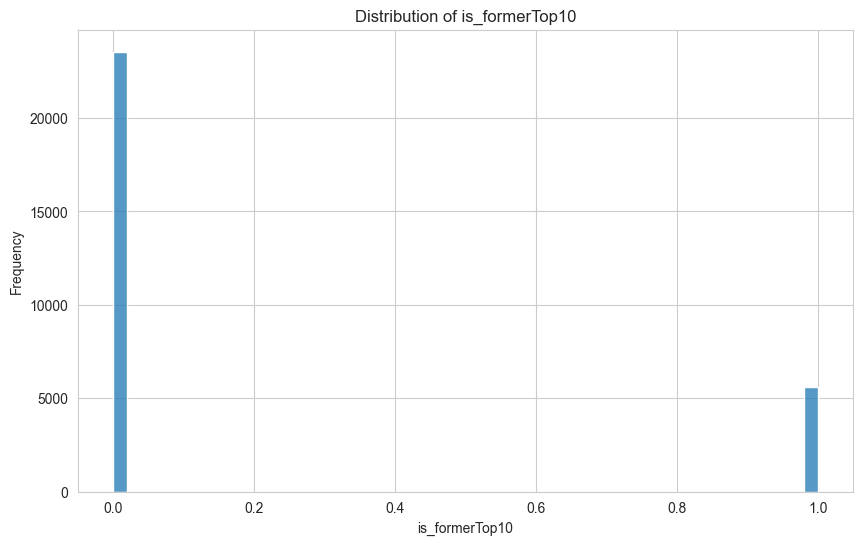

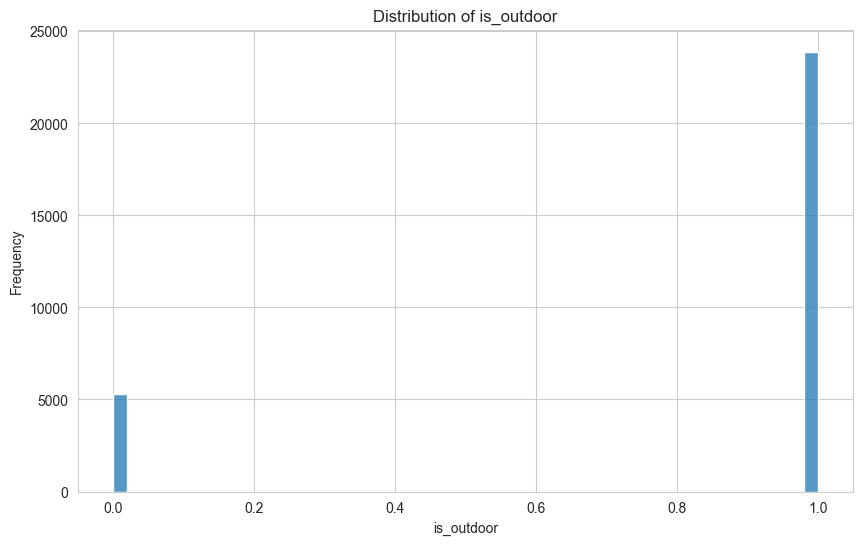

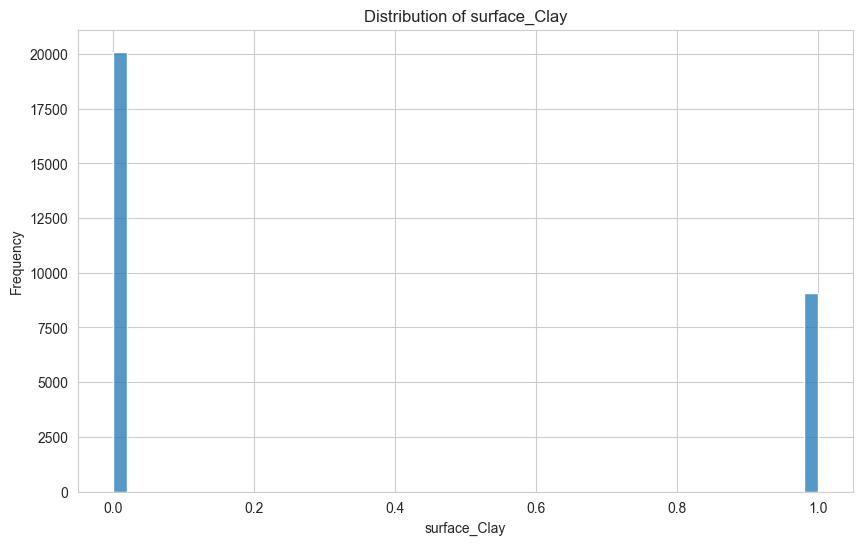

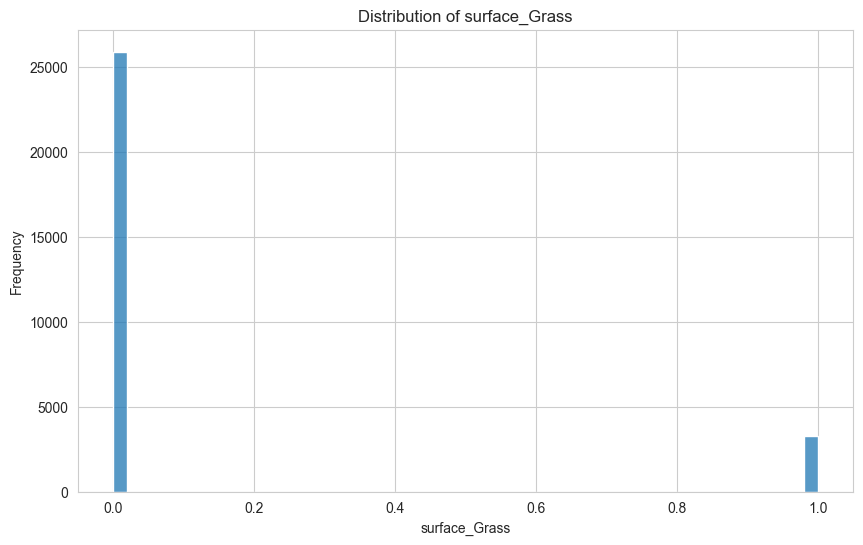

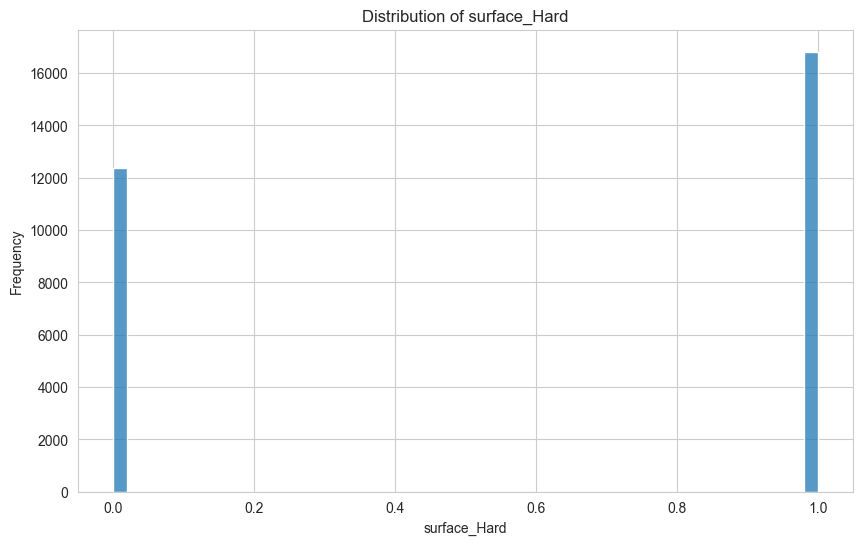

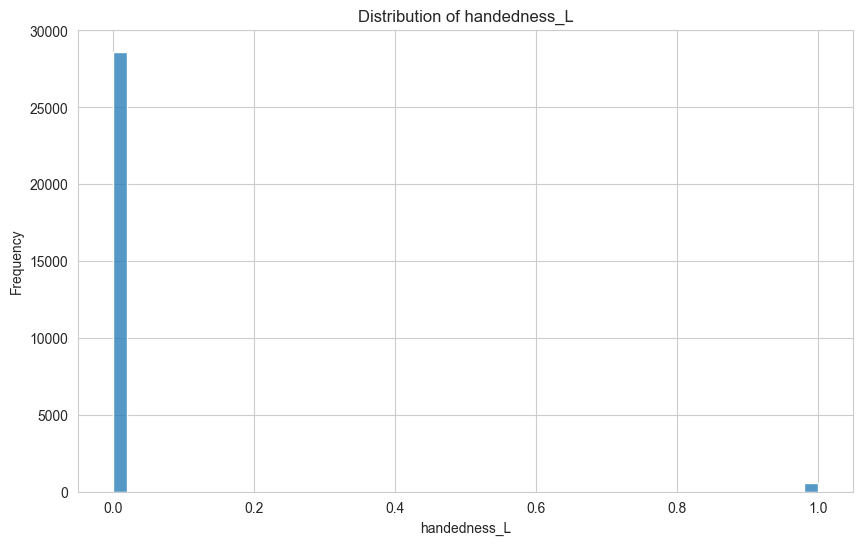

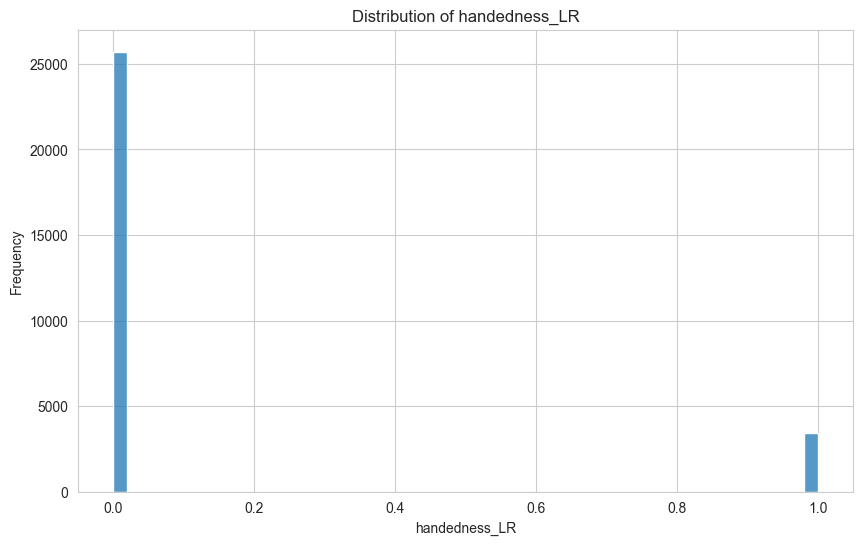

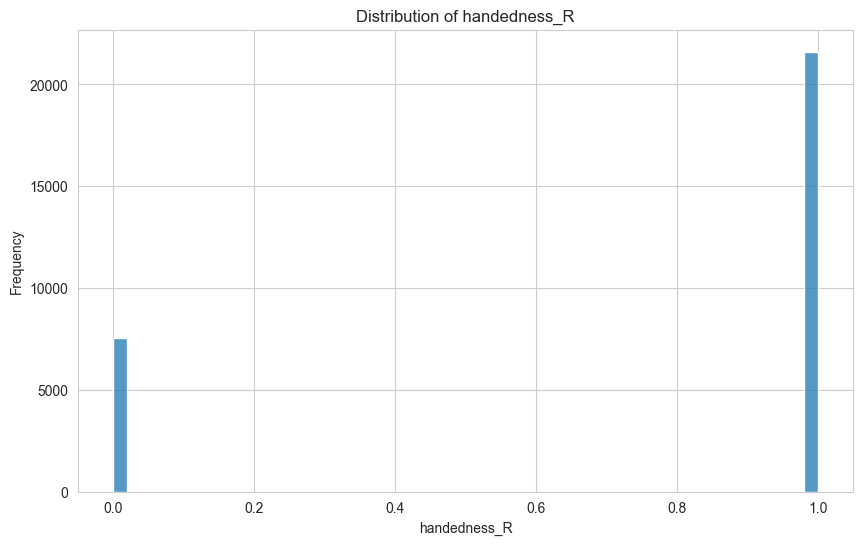

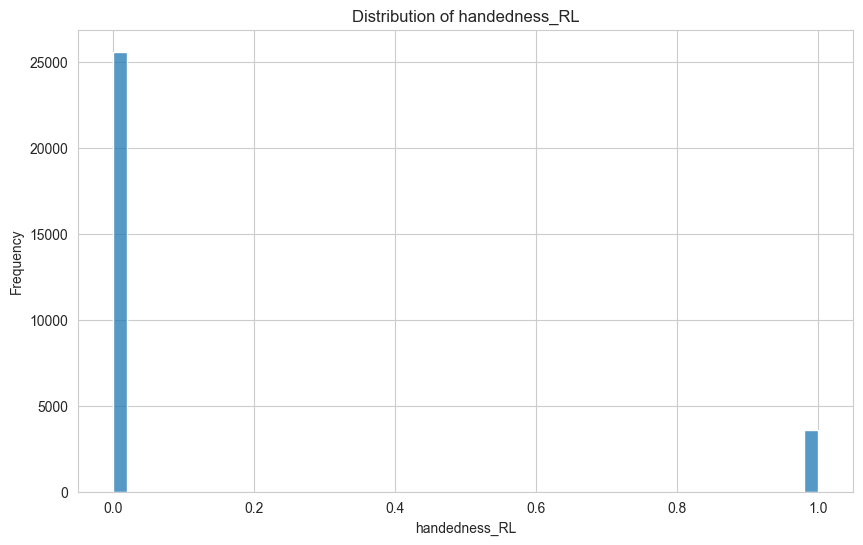

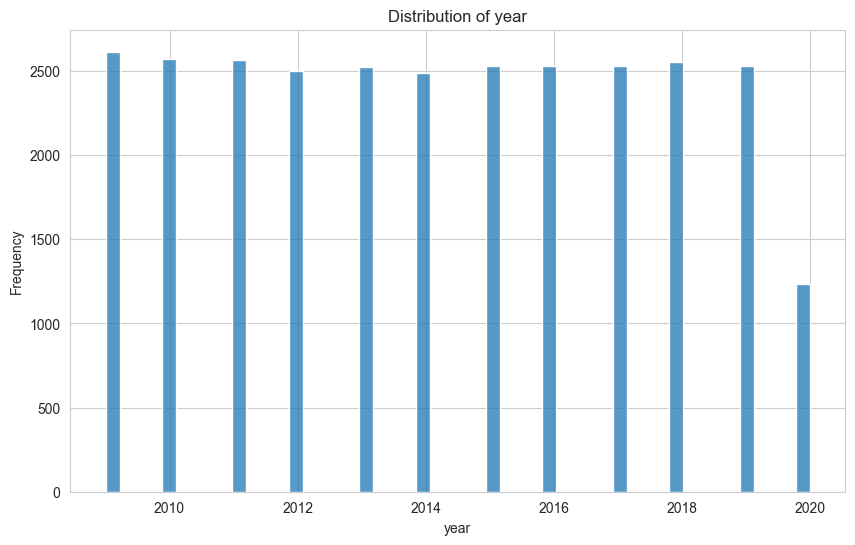

In [11]:
# Combine features that need the same scaling
scaling_cols = normal_cols + bimodal_cols + spike_cols

# Create transformers
scaling_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())  # Standardizing with mean-centering
])
ordinal_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler(feature_range=(0, 1)))  # Normalizing between 0 and 1
])

# Create preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('scale', scaling_transformer, scaling_cols),
        ('ordinal', ordinal_transformer, ordinal_cols),
        ('unchanged', 'passthrough', binary_cols),
    ], remainder='passthrough'  # leave remaining features unscaled
)

# Reorder columns before transformation to check min-max values
X_train = X_train[scaling_cols + ordinal_cols + binary_cols + [col for col in X_train.columns if col not in scaling_cols + ordinal_cols + binary_cols]]
X_test = X_test[scaling_cols + ordinal_cols + binary_cols + [col for col in X_test.columns if col not in scaling_cols + ordinal_cols + binary_cols]]

# Check min-max values beforehand
display(X_train.describe().loc[['min', 'max']])
display(X_test.describe().loc[['min', 'max']])

# Fit on training data and transform both train and test data
X_train_scaled = preprocessor.fit_transform(X_train)
X_test_scaled = preprocessor.transform(X_test)

# Convert back to DataFrame
X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# Check min-max values after scaling
display(X_train.describe().loc[['min', 'max']])
display(X_test.describe().loc[['min', 'max']])

# Visualize the distribution of the feature columns
for col in X_train.columns:
    plot_histogram(X_train[col])


##### Correlation (Feature Selection) #####

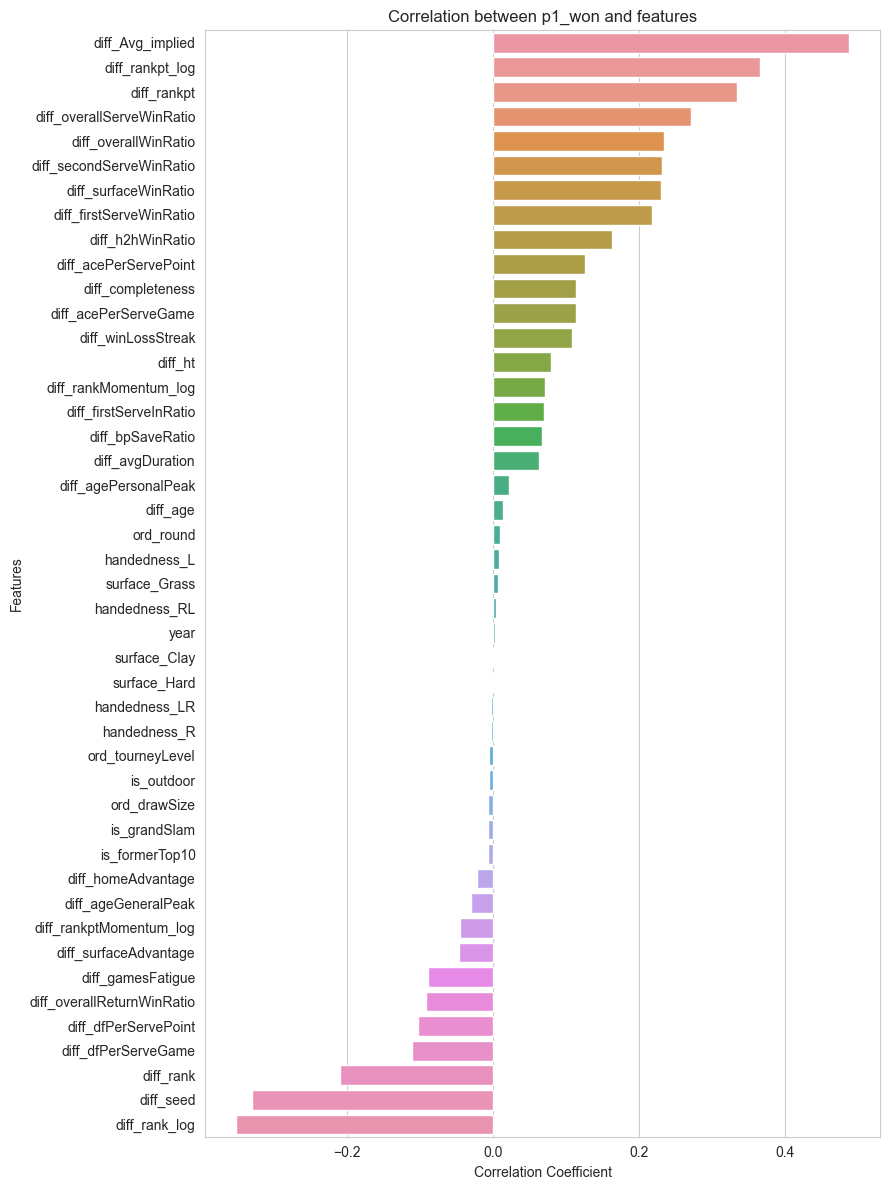

In [12]:
# Show the correlation between targets and features
fig, ax = plt.subplots(figsize=(9, 12))

# Calculate the correlation between y_train and feature columns
corr = pd.concat([X_train, y_train], axis=1).corr().loc[y_train.name, feature_cols].sort_values(ascending=False)

# Plot
sns.barplot(x=corr, y=corr.index, ax=ax)
ax.set_title(f'Correlation between {y_train.name} and features')
ax.set_xlabel('Correlation Coefficient')
ax.set_ylabel('Features')

plt.tight_layout()
plt.show()

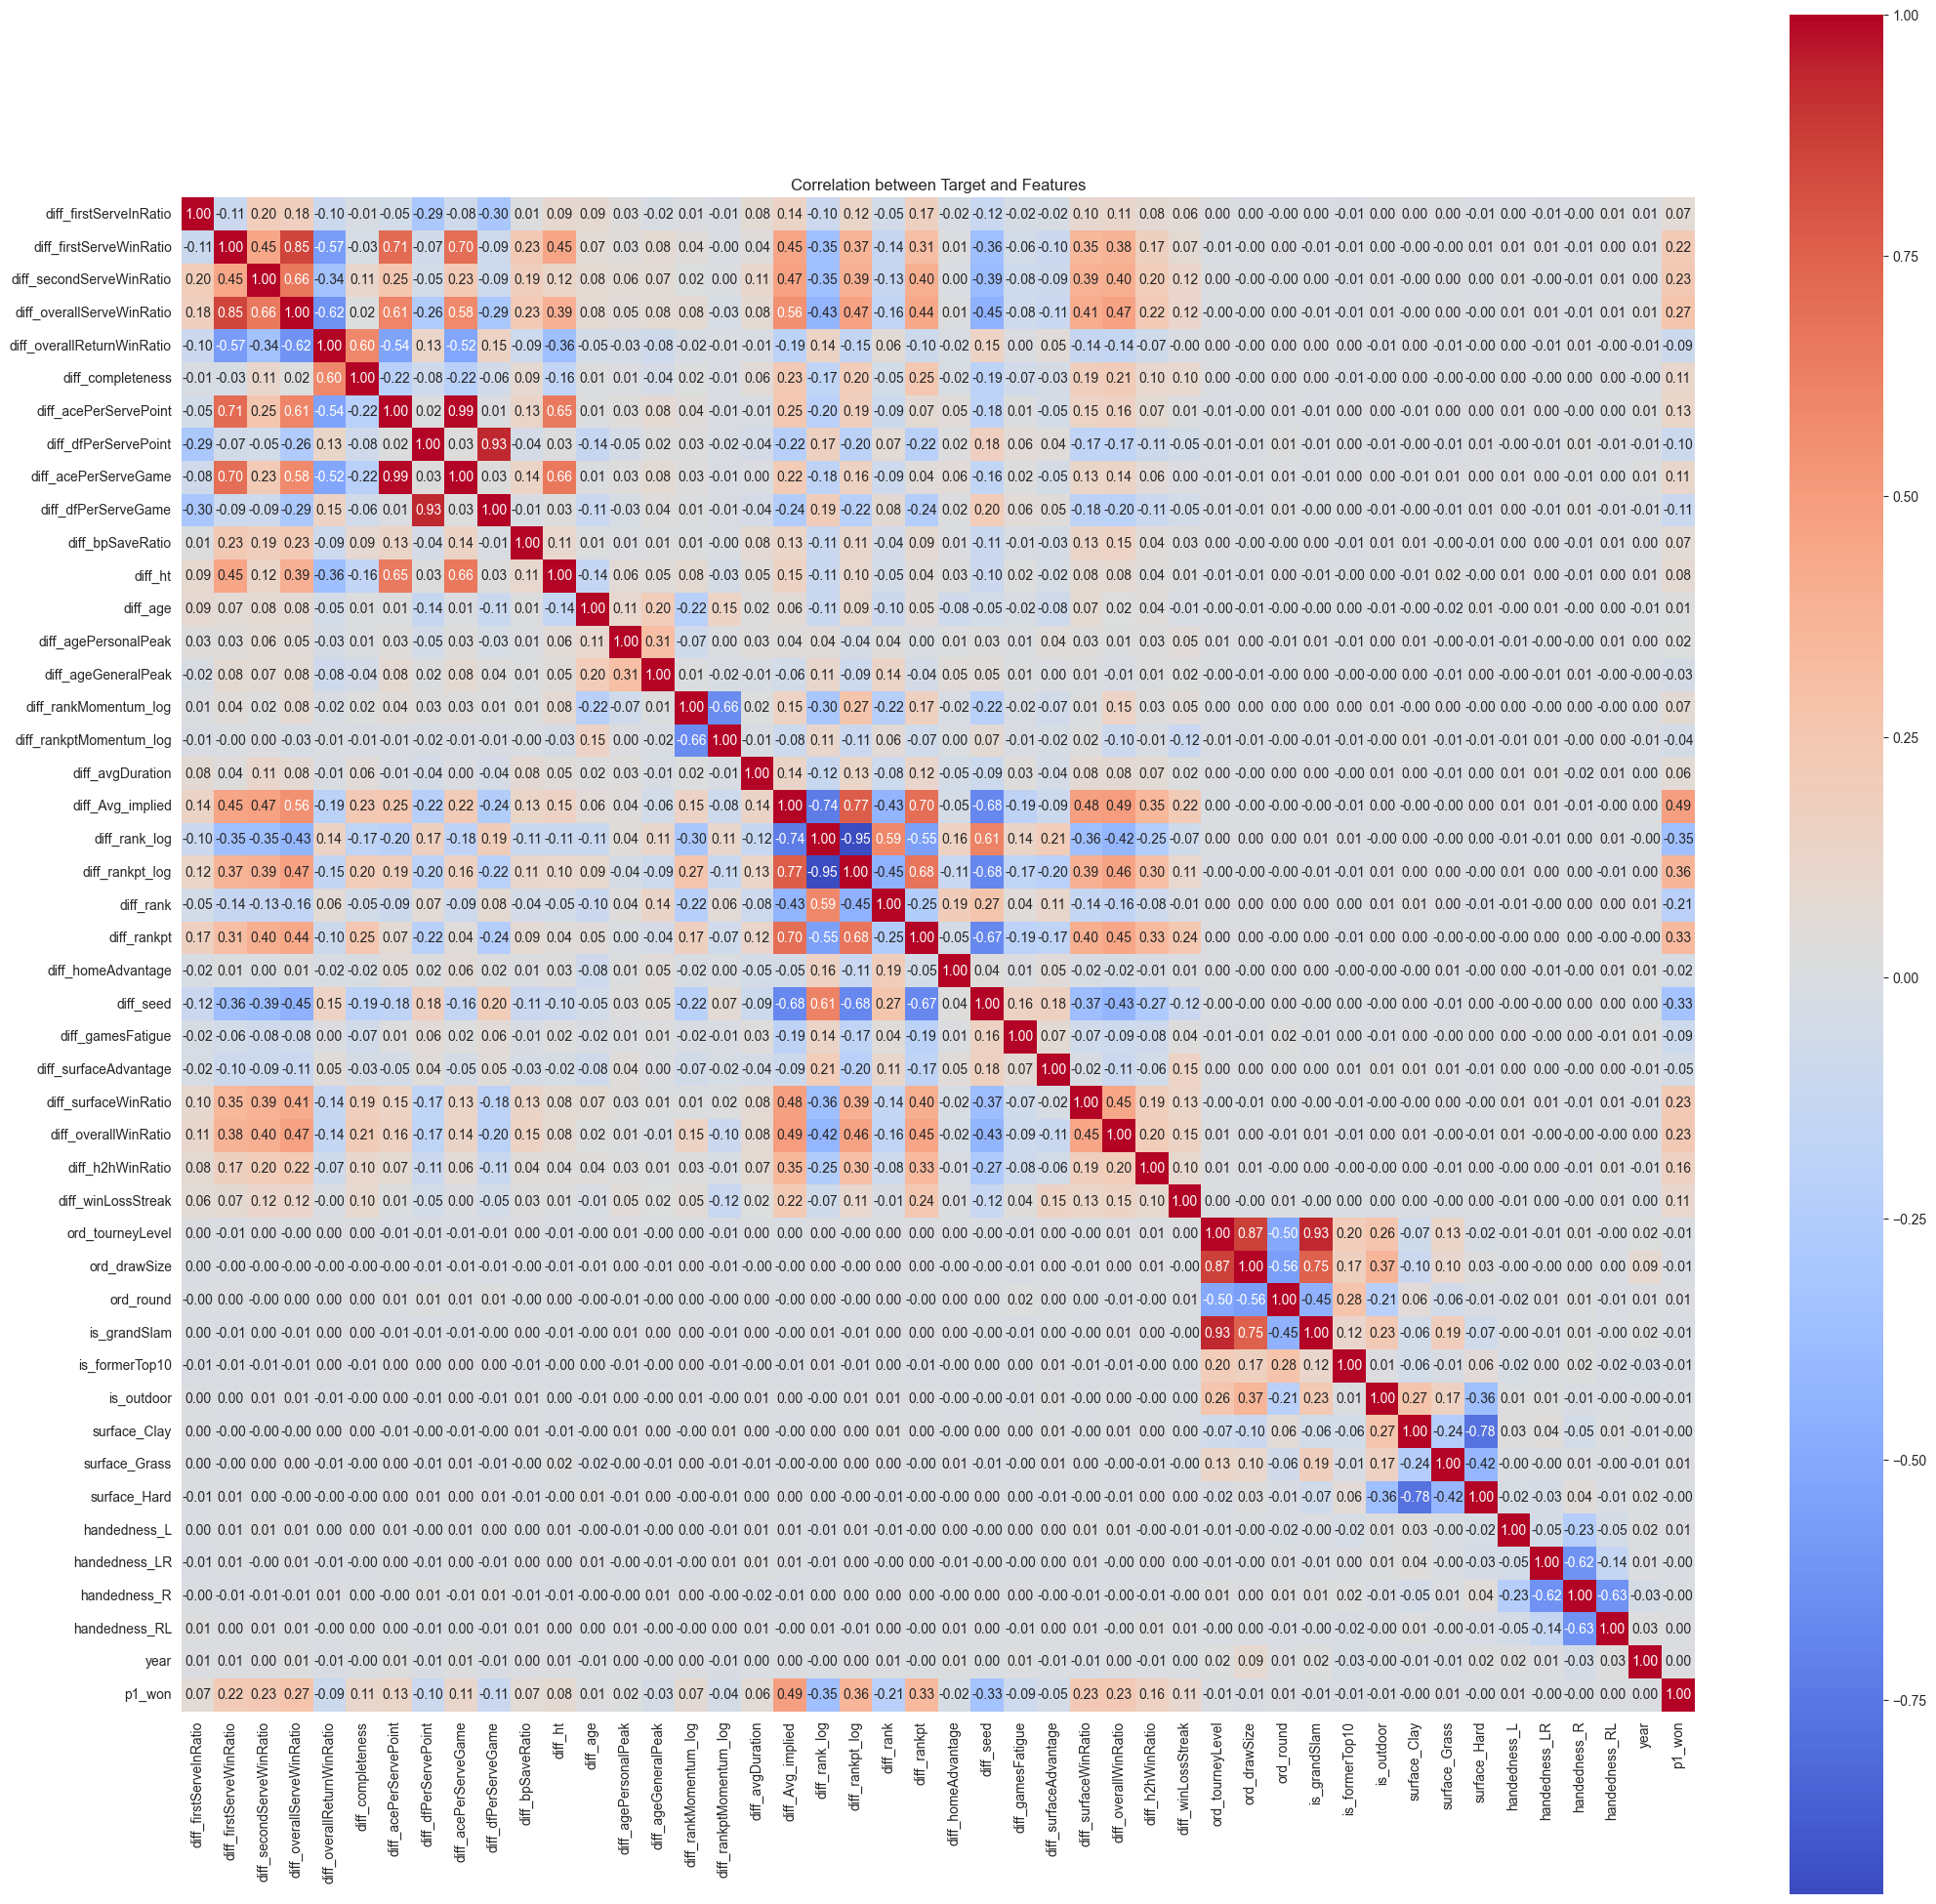

In [13]:
# Calculate the correlation matrix
corr_matrix = pd.concat([X_train, y_train], axis=1).corr()

# Create the heatmap to check multicollinearity
plt.figure(figsize=(25, 25))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', cbar=True, square=True, fmt='.2f')
plt.title('Correlation between Target and Features')
plt.show()


##### Multicollinearity (Feature Selection) #####

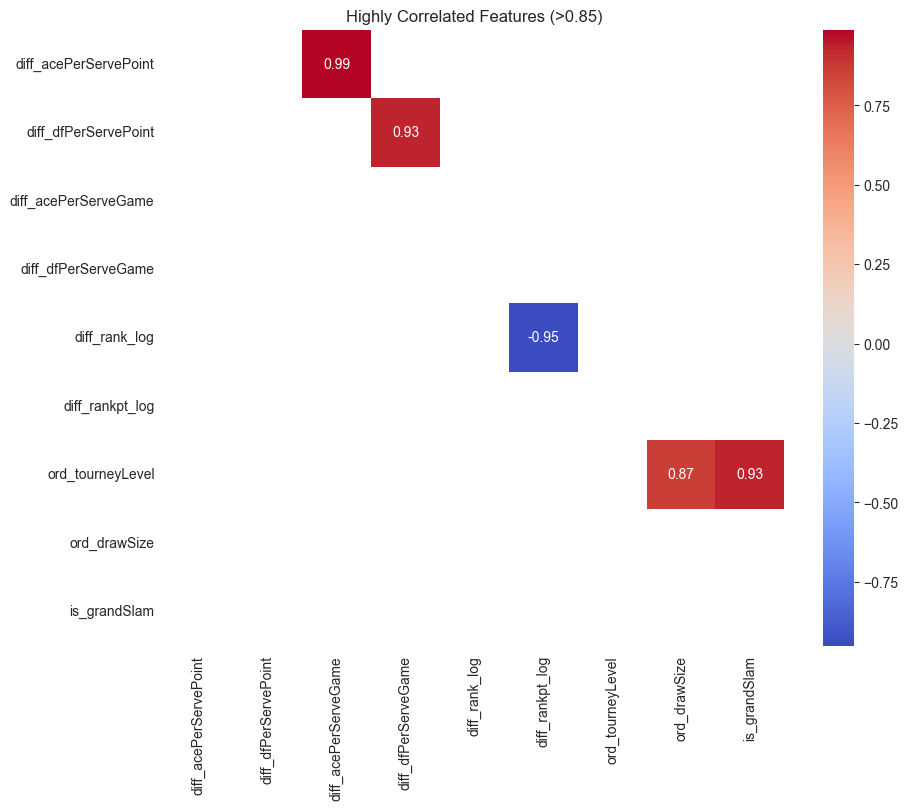

In [14]:
# Calculate the correlation matrix
corr_matrix = pd.concat([X_train, y_train], axis=1).corr()

# Create a mask for correlations greater than 0.85 and exclude the diagonal
mask_high_corr = np.abs(corr_matrix) > 0.85
np.fill_diagonal(mask_high_corr.values, False)  # Set diagonal to False to exclude 1.0 correlations

# Extract the features that have at least one high correlation
high_corr_features = [column for column in mask_high_corr.columns if any(mask_high_corr[column])]

# Filter the correlation matrix to only include these features
filtered_corr_matrix = corr_matrix.loc[high_corr_features, high_corr_features]

# Create a mask for the upper triangle
mask_upper_triangle = np.triu(np.ones_like(filtered_corr_matrix, dtype=bool), k=1)

# Create a new mask for the filtered matrix to only show high correlations and upper triangle
filtered_mask = mask_high_corr.loc[high_corr_features, high_corr_features] & mask_upper_triangle

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(filtered_corr_matrix, annot=True, cmap='coolwarm', cbar=True, fmt='.2f', mask=~filtered_mask)
plt.title('Highly Correlated Features (>0.85)')
plt.show()


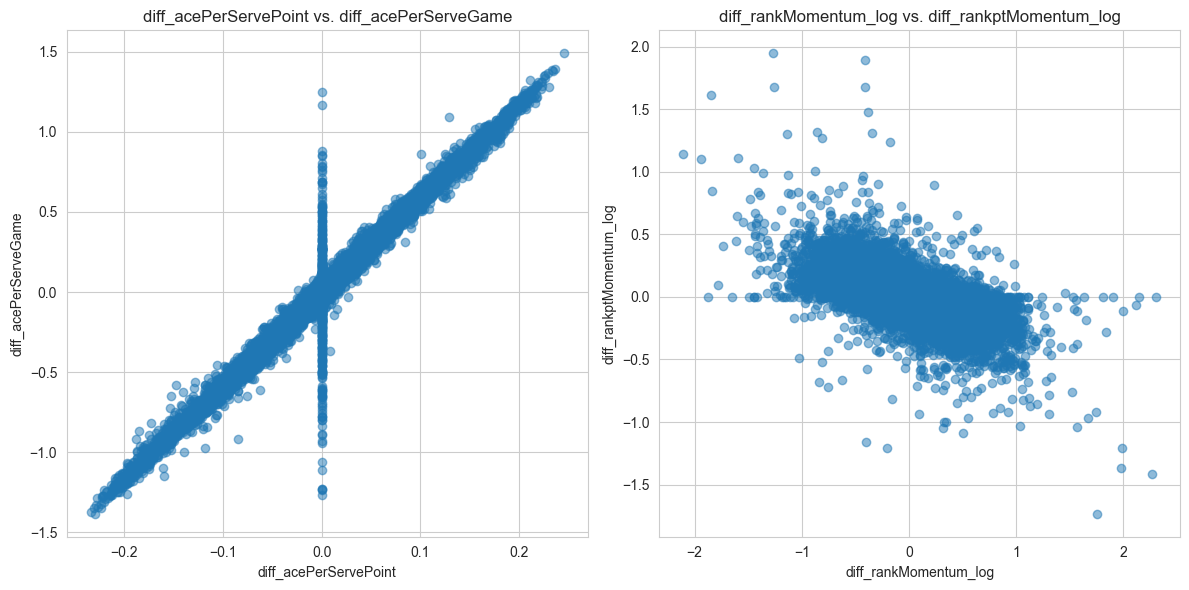

In [15]:
# Create the scatter plot for the first pair of variables
plt.figure(figsize=(12, 6))

# Create the scatter plot for the second pair of variables
plt.subplot(1, 2, 1)
plt.scatter(df['diff_acePerServePoint'], df['diff_acePerServeGame'], alpha=0.5)
plt.title('diff_acePerServePoint vs. diff_acePerServeGame')
plt.xlabel('diff_acePerServePoint')
plt.ylabel('diff_acePerServeGame')

plt.subplot(1, 2, 2)
plt.scatter(df['diff_rankMomentum_log'], df['diff_rankptMomentum_log'], alpha=0.5)
plt.title('diff_rankMomentum_log vs. diff_rankptMomentum_log')
plt.xlabel('diff_rankMomentum_log')
plt.ylabel('diff_rankptMomentum_log')

# Show the plot
plt.tight_layout()
plt.show()

In [16]:
# Define highly correlated features to remove
high_corr_features_to_remove = ['diff_firstServeWinRatio', 
                                'diff_acePerServeGame', 'diff_dfPerServeGame', 
                                'diff_rankMomentum_log', 'diff_rank_log',
                                'ord_tourneyLevel']

# Remove the highly correlated features
X_train = X_train.drop(columns=high_corr_features_to_remove)
X_test = X_test.drop(columns=high_corr_features_to_remove)

# Show the shape of the data after removing highly correlated features
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")


Shape of X_train: (29166, 39)
Shape of X_test: (4955, 39)
Shape of y_train: (29166,)
Shape of y_test: (4955,)


In [17]:
# Reset indexes
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

# Combine X and y
train_data = pd.concat([X_train, y_train], axis=1)
test_data = pd.concat([X_test, y_test], axis=1)

# Combine train and test
combined_df = pd.concat([train_data, test_data], axis=0)

# Export dataset to excel
combined_df.to_excel('_data/_matches_list_v6.xlsx', index=False)